In [1]:
import numpy as np
import pandas as pd
from os import *
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
# Select filename
fname_noext = 'SSL_Berkeley/bkg_205_FTh_2mins'

# Select file extension
extension = 'txt'
fname = fname_noext + "." + extension

# Select module number
mod_number = 0

# Excluded detectors
excludeDetectors = []

# Excluded channels
excludeChannels = []

In [3]:
# Selection of the active channels for the common mode noise determination
# Change the variables excludeDetectors and excludeChannels to provide the
# channels to be removed from the calculation, if all channels are to be
# used set the two variables to [].
# Numbering is from detector #0 (ch. #0 to ch. #7) to detector #3 (ch. #24
# to ch. #31)

global chMask

Mask = np.ones((32,1),dtype='int')

for exclude in excludeDetectors:
    for i in range(8):
        Mask[exclude*8+i] = 0
for exclude in excludeChannels:
    Mask[exclude] = 0

chMask = (Mask > 0).nonzero()[0]
print('Common Mode Noise active channels are: {}'.format(chMask))

Common Mode Noise active channels are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


In [4]:
# Function used to determine the pedestals. It uses only the events where
# all signals are below thr. The algorithm calculates the pedestals channel
# by channel by removing iteratively the channels that fall outside the
# range -nsigma*sigma_i < mean_i < nsigma*sigma_i. nsigma has a default
# value of 3.0.
# The function returns the pedestals (mean) and the standard deviation of
# the values selected to determine the pedestals (std)

def Pedestals(ev, thr, nsigma=3.):
    sel = np.ones(ev.shape,dtype='int')
    for i in range(32):
        sel[:,i] *= (ev[:,i] <= thr[i])
    std = np.zeros_like(ev[0,:])
    mean = np.zeros_like(std)
    for i in range(32):
        idx = (sel[:,i] > 0).nonzero()[0]
        v = ev[idx,i]
        mean[i] = v.mean()
        stdprev = v.std()
        idx = (np.abs(v-mean[i]) < nsigma*stdprev).nonzero()[0]
        mean[i] = v[idx].mean()
        std[i] = v[idx].std()
        while (std[i] < stdprev):
            stdprev = std[i]
            idx = (np.abs(v-mean[i]) < nsigma*stdprev).nonzero()[0]
            mean[i] = v[idx].mean()
            std[i] = v[idx].std()
    return [mean, std]

In [5]:
# Function used to determine the common mode noise. It subtracts the pedestals
# from the ADC values and uses the same algorithm of the Pedestal function,
# this time event by event, to select the channels without signal.
# The function returns the common mode channel selection matrix (ch), the number
# of common mode channels on each event (chn), the raw common mode noise (mean),
# and the event standard devation of the common mode channels (std) that can be
# used to select events where the common mode can be calculated correctly (those
# with low std).

def CMNchannels(ev, peds, nsigma=3.):
    global chMask
    v = ev-peds
    v = v[:,chMask]
    ch = np.zeros_like(v)
    stdprev = v.std(axis=1).reshape(v.shape[0],1)
    std = np.zeros_like(stdprev)
    mean = v.mean(axis=1)
    chn = np.zeros_like(std)
    for i in range(v.shape[0]):
        vv = v[i,:]
        chmax = (vv == vv.max()).nonzero()[0]
        chidx = np.array(range(v.shape[1]))
        chidx = np.delete(chidx,chmax)
        stdprev[i] = vv[chidx].std()
        mean[i] = vv[chidx].mean()
        chidx = (np.abs(vv-mean[i]) < nsigma*stdprev[i])
        idx = chidx.nonzero()[0]
        mean[i] = vv[idx].mean()
        std[i] = vv[idx].std()
        while (std[i] < stdprev[i]):
            stdprev[i] = std[i]
            chidx = (vv-mean[i] < nsigma*stdprev[i])
            idx = chidx.nonzero()[0]
            mean[i] = vv[idx].mean()
            std[i] = vv[idx].std()
        ch[i,:] = chidx[:]
        chn[i] = len(idx)
    return [ch, chn, mean, std]

In [6]:
# Function used by the minimization to determine the common mode noise coupling
# to thee various channels (common mode noise "gain"). It uses global variables
# containing the pedestal subtracted event data and the common mode noise selection
# matrix.

def cmnGain(p):
    global cmnEv
    global cmnCh
    n = cmnEv.shape[0]
    g = np.array(p)
    I = np.ones((n,1))
    g_sum = (((np.outer(I, g))*cmnCh).sum(axis=1)).reshape(n,1)
    cmn = ((cmnEv*cmnCh).sum(axis=1)).reshape(n,1)
    cmn = cmn/g_sum
    cmn_matrix = np.outer(cmn, g)
    y = (((cmnEv-cmn_matrix)*cmnCh)**2).sum()
    return y

In [7]:
# Function used to remove the common mode noise from the event data. It uses
# the raw event data, the pedestals, the common mode channels selection matrix
# and the common mode noise coupling gains. The function returns the pedestal
# and common mode corrected event data (v) and the event common mode noise (cmn).
# Note: the common mode noise is removed only for the active channels

def removeDisturbances(ev, peds, ch, g):
    global chMask
    v = ev-peds
    vv = v[:,chMask]
    n = vv.shape[0]
    I = np.ones((n,1))
    g_sum = (((np.outer(I, g))*ch).sum(axis=1)).reshape(n,1)
    cmn = ((vv*ch).sum(axis=1)).reshape(n,1)
    cmn = cmn/g_sum
    cmn_matrix = np.outer(cmn, g)
    vv = vv-cmn_matrix
    for i,j in enumerate(chMask):
        v[:,j] = vv[:,i]
    return [v, cmn]

In [8]:
# Function used to determine the pedestals (ch_mean) and the noise (ch_std)
# after the pedestals and the common mode noise has been subtracted from the
# event data. The new pedestals should all be "zero" (within the noise limits)
# and the new noise standard deviations should be equal or smaller than the
# one calculated at the beginning by the pedestals determination function.

def histParameters(energy, thr, nsigma = 3.):
    ch_std = np.zeros(32)
    ch_mean = np.zeros(32)
    for i in range(32):
        idx = (energy[:,i] < thr).nonzero()[0]
        data = energy[idx,i]
        old_std = data.std()
        ch_mean[i] = data.mean()
        idx = (np.abs(data-ch_mean[i]) < nsigma*old_std).nonzero()[0]
        ch_std[i] = data[idx].std()
        ch_mean[i] = data[idx].mean()
        while (ch_std[i] < old_std):
            old_std = ch_std[i]
            idx = (np.abs(data-ch_mean[i]) < nsigma*old_std).nonzero()[0]
            ch_std[i] = data[idx].std()
            ch_mean[i] = data[idx].mean()
    return [ch_mean, ch_std]

In [9]:
# Load the file. Notice that this is very slow, be patient!

try:
    ev, evtype, module, chtype, channel, adc = np.loadtxt(fname, dtype='int', comments='#', usecols=(0, 1, 2, 3, 4, 5), unpack=True)
    N = np.unique(ev)
except:
    pass

In [10]:
# Print the number of events in the file

print('Events in file: ', len(N))
Event = []

idx = (module == mod_number).nonzero()[0]  # REMEMBER TO UPDATE THE MODULE NUMBER !!!!!!!!!!!!!!
evn = ev[idx]
ch = channel[idx]
val = adc[idx]

evnw = evn.view()
chw = ch.view()
valw = val.view()

# Determine the good events and store them in the Event list along with the event
# number and the channel numbers. This step eliminates all 0 and all 2047 events
# and the events where there is S&H saturation (changing the neg_saturation and
# the pos_saturation values can be used to play with saturation)

selected = 0
all_neg_saturation = 0
all_pos_saturation = 0
some_neg_saturation = 0
some_pos_saturation = 0
neg_saturation = 40.
pos_saturation = 2020.
if (len(N)):
    for n in N:
        # check only 40 rows at a time
        if (len(evnw) > 40):
            idx = (evnw[0:40] == n).nonzero()[0]
        else:
            idx = (evnw == n).nonzero()[0]
        # verify that the event contains 32 rows and all channels are present
        if ((len(idx) == 32) and (ch[idx].sum() == 496)):
            # verify saturation
            if ((valw[idx] <= neg_saturation).all()):
                all_neg_saturation += 1
            elif ((valw[idx] <= neg_saturation).any()):
                some_neg_saturation += 1
            elif ((valw[idx] >= pos_saturation).all()):
                all_pos_saturation += 1
            elif ((valw[idx] >= pos_saturation).any()):
                some_pos_saturation += 1
            else:
                Nch = chw[idx]
                ADCs = valw[idx]
                Event.append([n, Nch, ADCs])
                selected += 1
        ii = len(idx)
        evnw = evnw[ii:].view()
        chw = chw[ii:].view()
        valw = valw[ii:].view()

# Plot the good/bad events statistics
print('Real events: ', selected+all_neg_saturation+some_neg_saturation+all_pos_saturation+some_pos_saturation)
print('All negative saturated: ', all_neg_saturation)
print('Some negative saturated: ', some_neg_saturation)
print('All positive saturated: ', all_pos_saturation)
print('some positive saturated: ', some_pos_saturation)
print('Selected: ', selected)

Events in file:  86251
Real events:  86250
All negative saturated:  2
Some negative saturated:  0
All positive saturated:  980
some positive saturated:  2
Selected:  85266


In [11]:
# Prepare the event and pedestal variables for the analysis

global events
global peds
n = len(Event)
peds = np.zeros((1, 32))
events = np.empty((n, 32))
for i, data in enumerate(Event):
    events[i,:] = data[2]

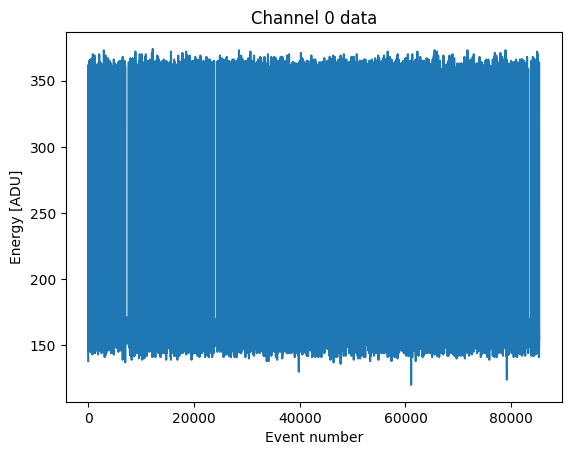

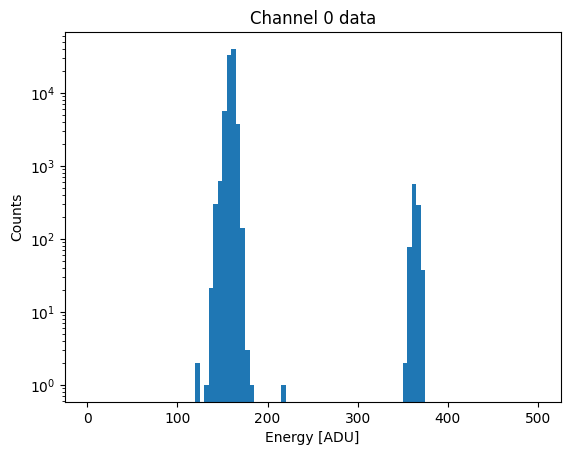

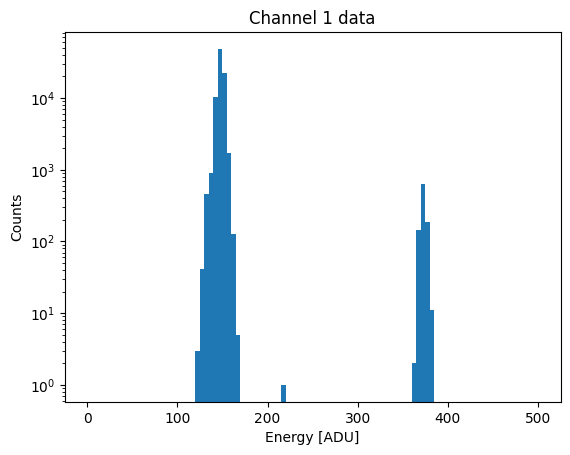

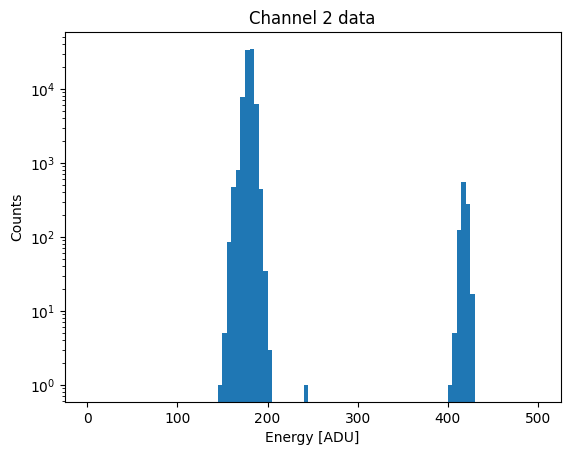

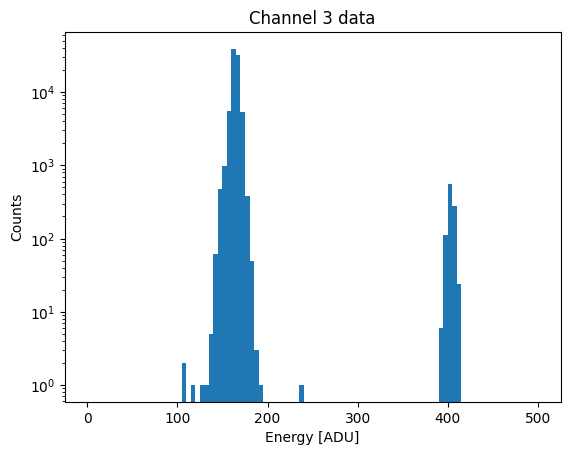

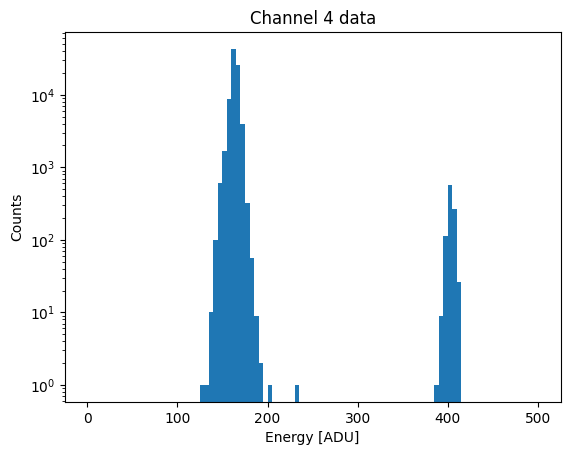

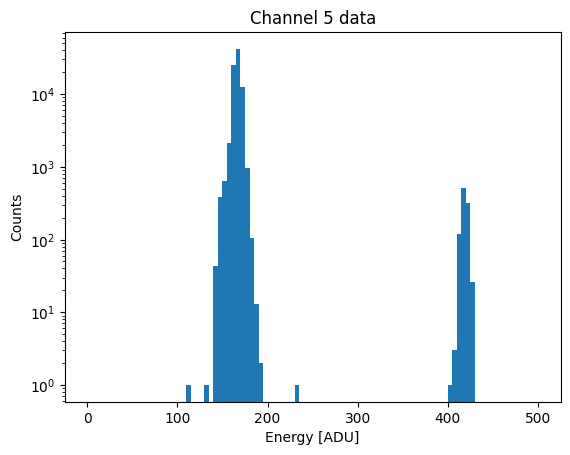

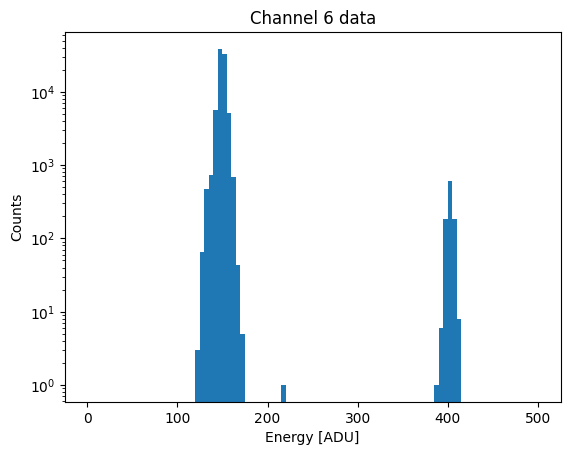

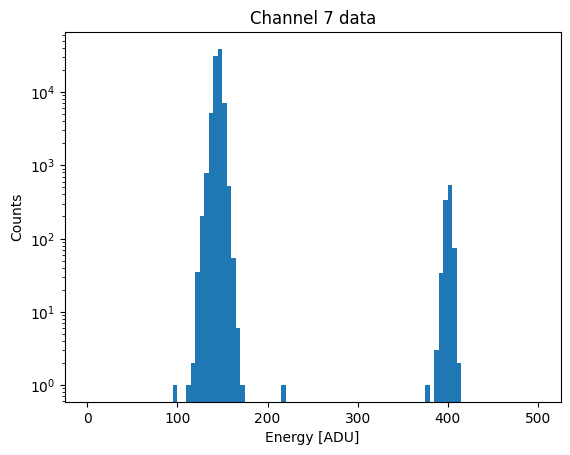

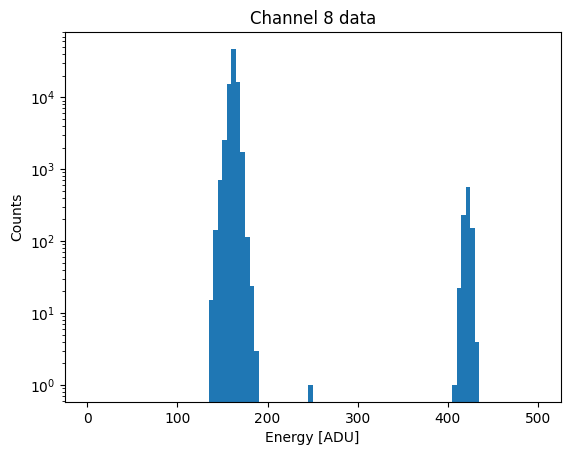

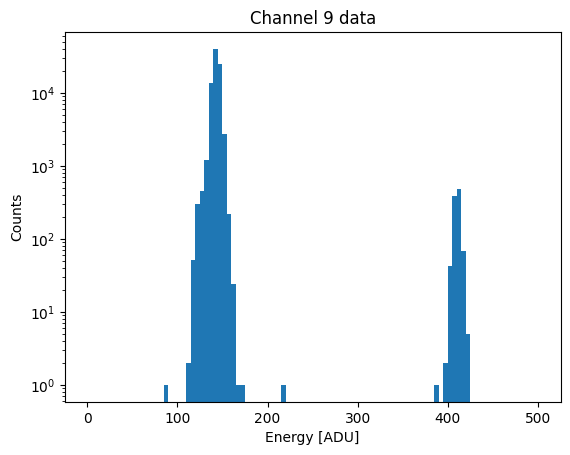

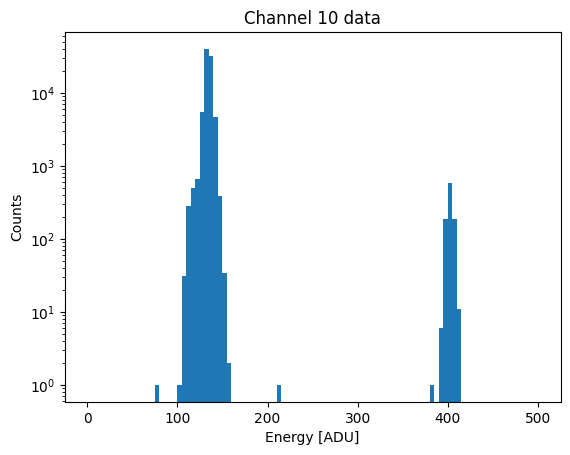

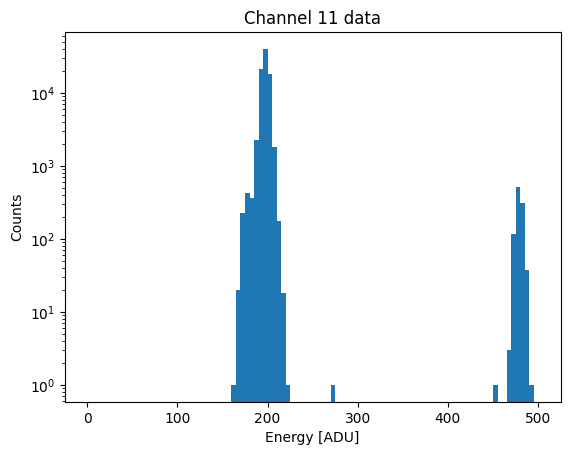

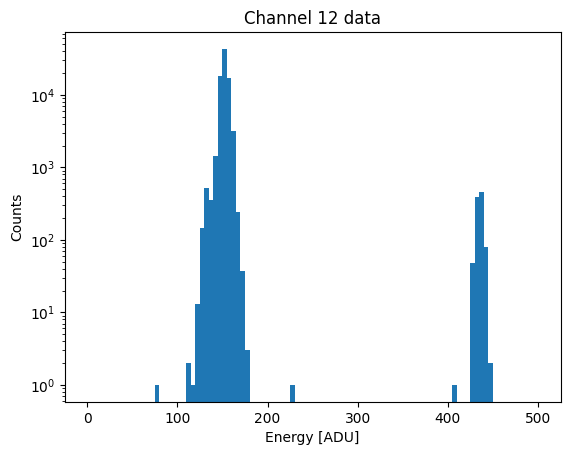

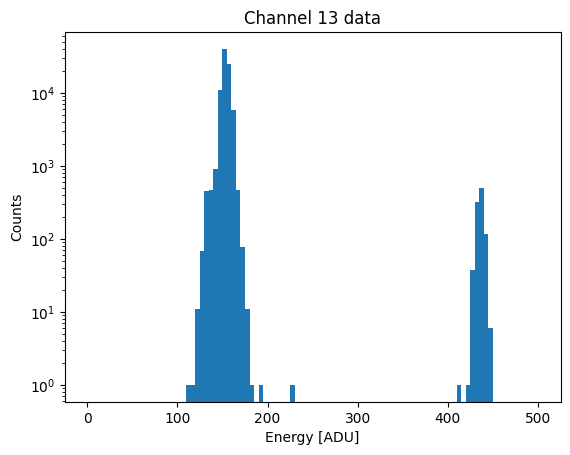

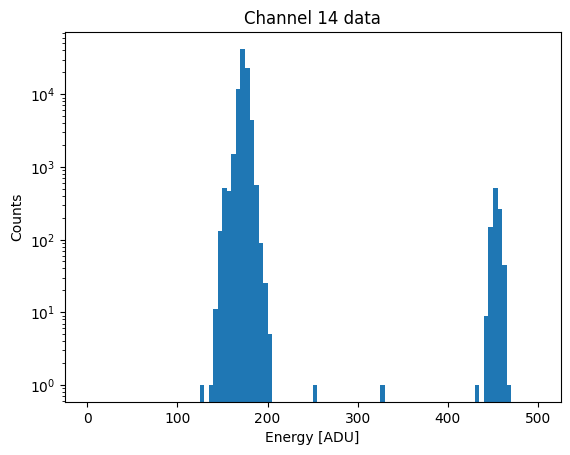

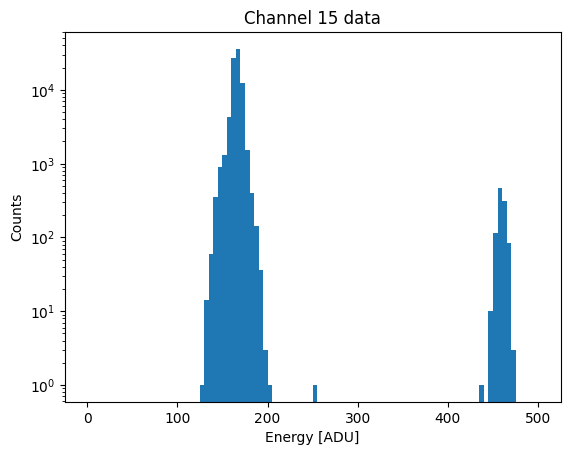

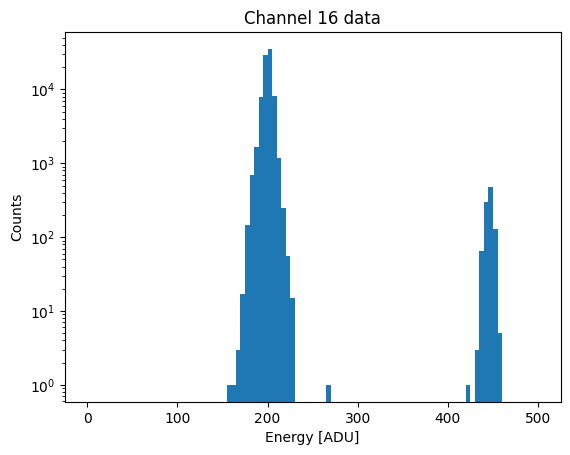

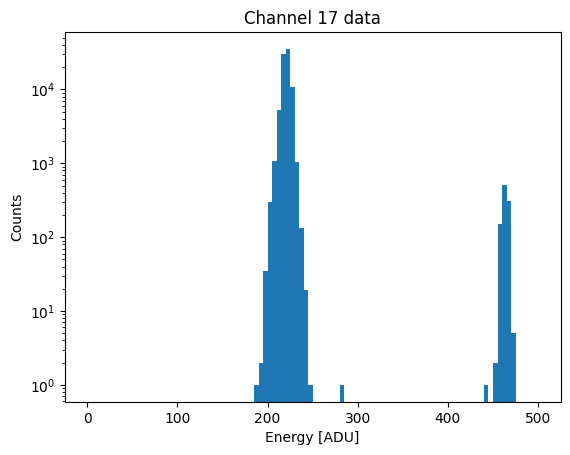

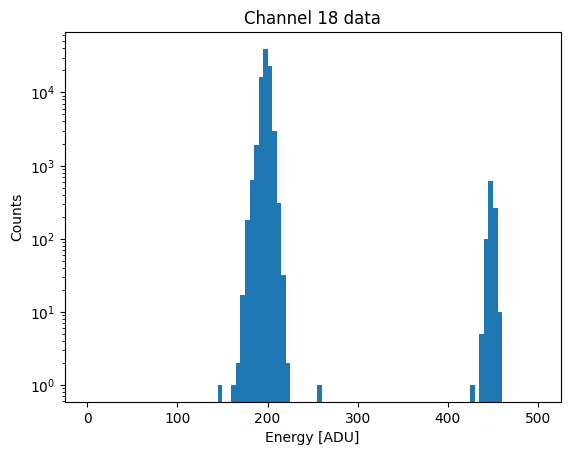

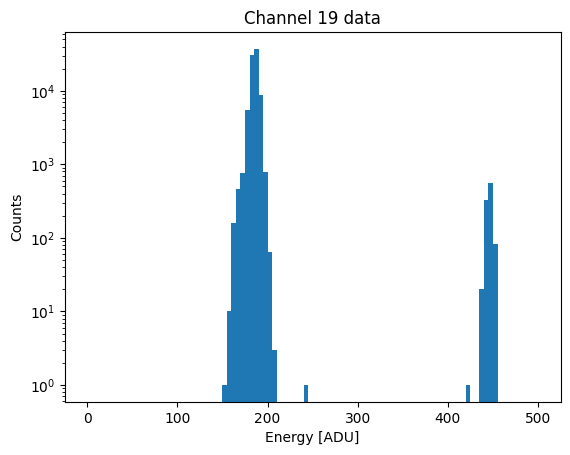

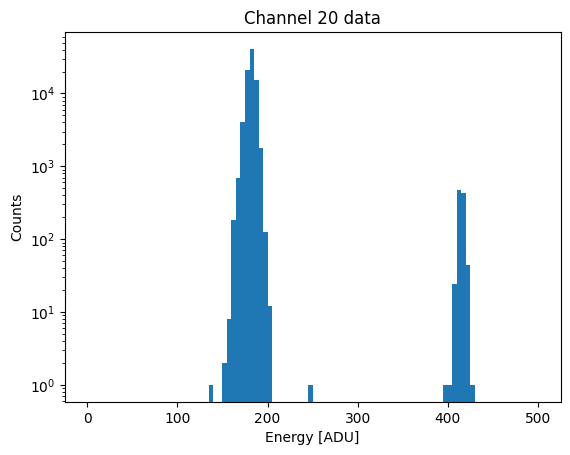

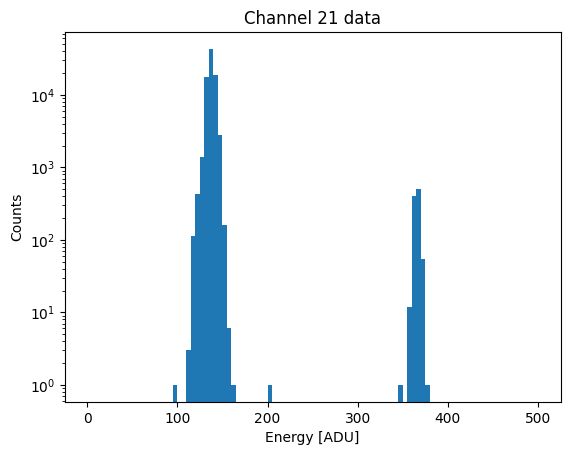

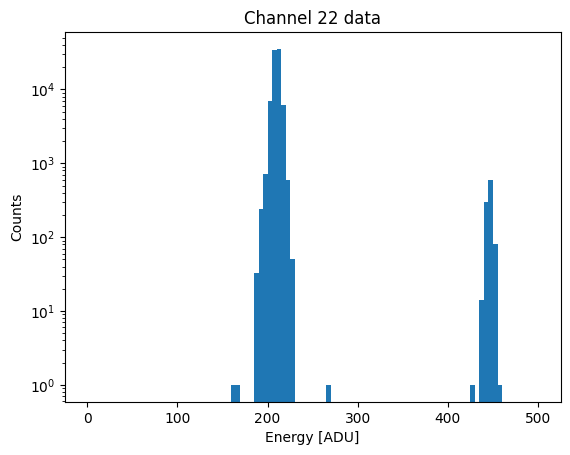

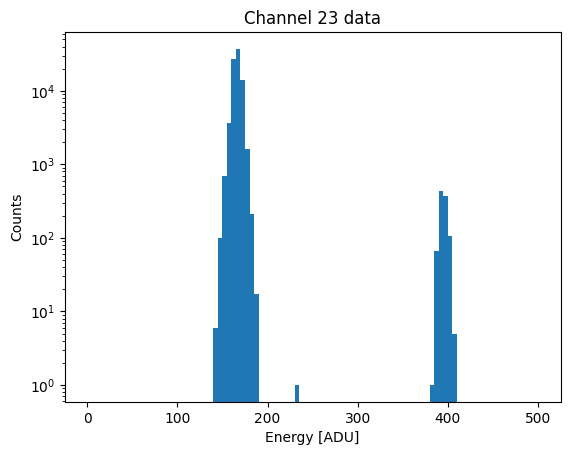

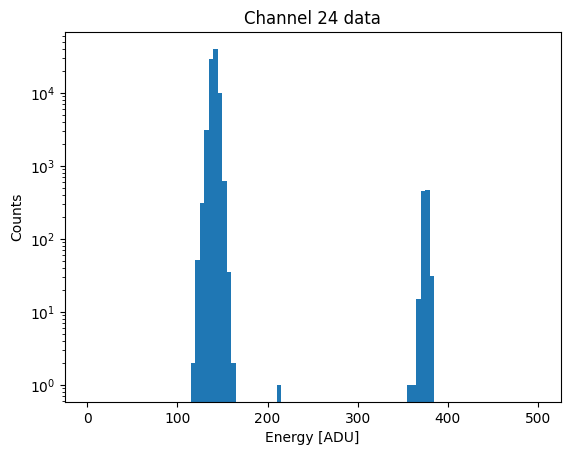

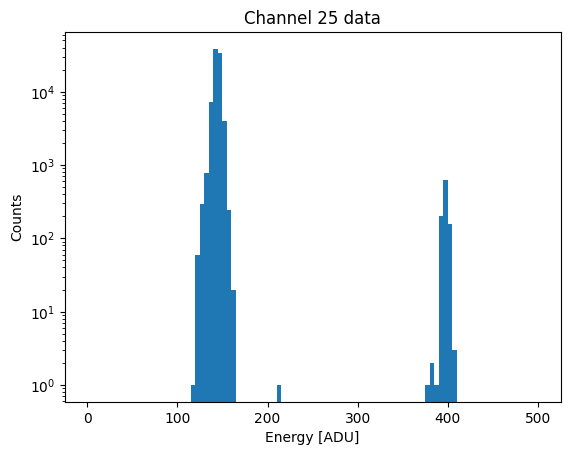

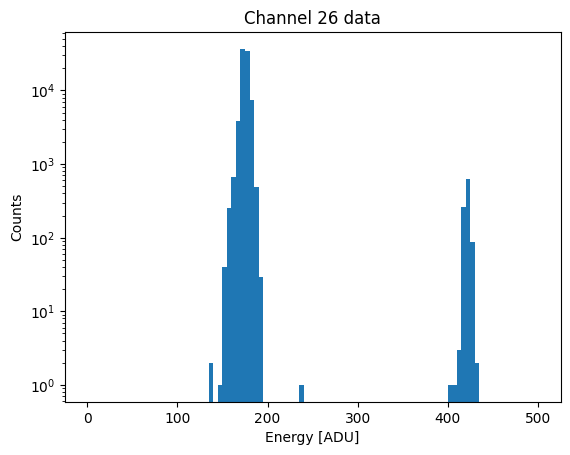

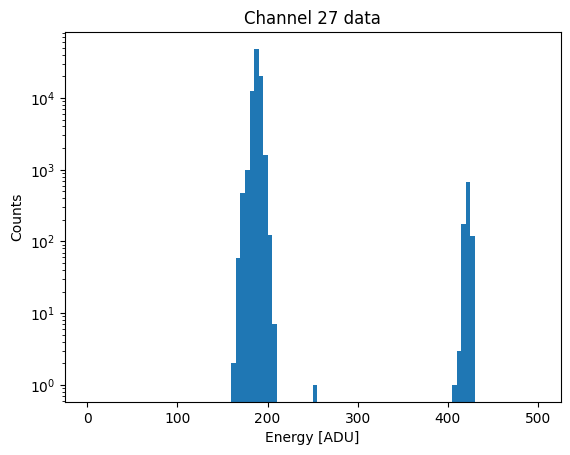

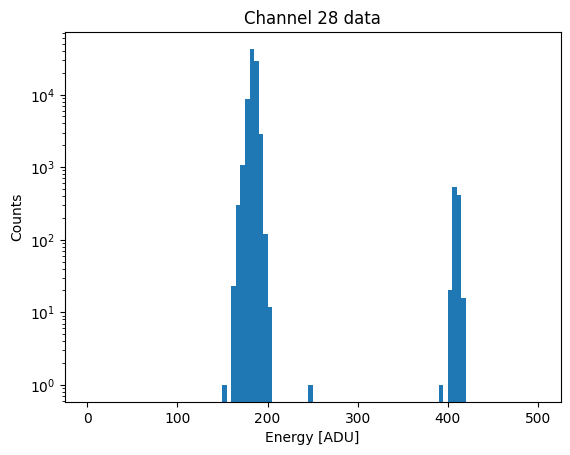

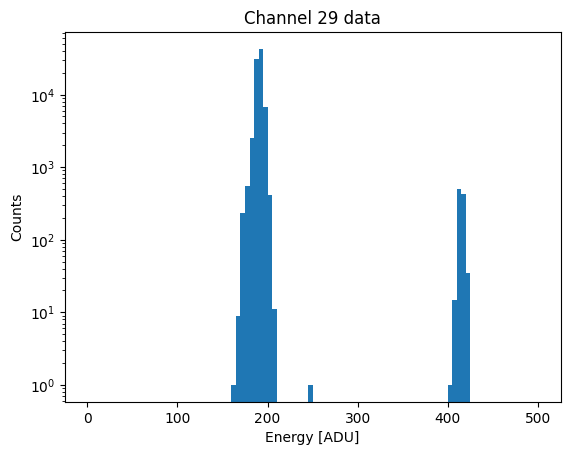

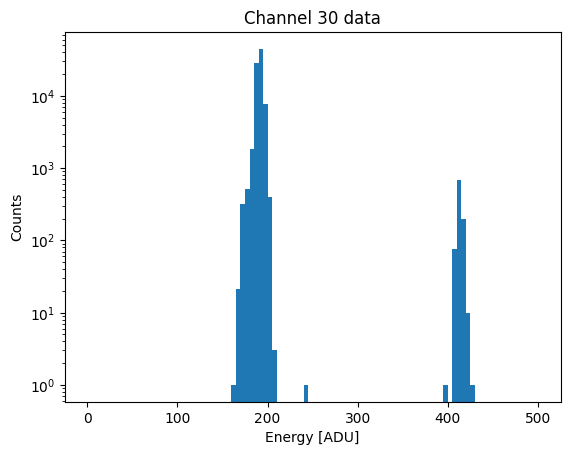

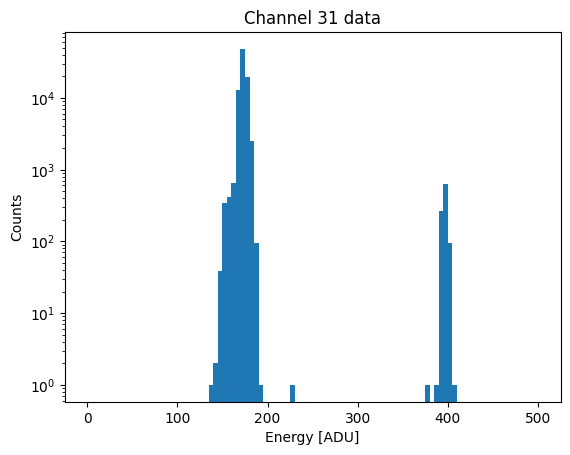

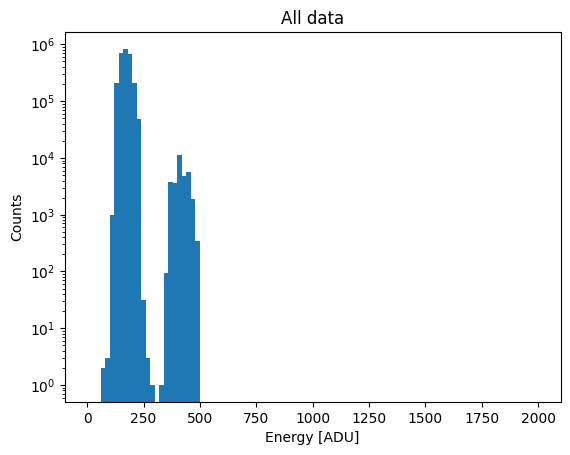

Channel averages:
 [161.42185631 150.40570685 181.899362   166.68515    165.81073347
 168.6837661  152.16884808 147.74235921 164.56381207 145.81755917
 137.16669012 199.78501396 155.2796308  156.57028593 176.12993456
 168.57758075 202.24166725 222.93204794 200.27785987 187.75713649
 183.80424788 139.89123449 212.0696057  168.36097624 143.23054911
 146.81210565 177.55390191 190.14580255 185.82405648 192.80300471
 193.04670091 175.06955879] 



In [12]:
# Plot raw data histograms channel by channel (also the sequential data aquisitions
# for channel 0) and all together

i = 0
plt.plot(events[:,i])
plt.title('Channel {} data'.format(i))
plt.xlabel('Event number')
plt.ylabel('Energy [ADU]')
#plt.axis([0,200,0,200])
plt.show()
for i in range(32):
    plt.hist(events[:,i],100,(0,500))
    plt.semilogy()
    plt.title('Channel {} data'.format(i))
    plt.xlabel('Energy [ADU]')
    plt.ylabel('Counts')
    plt.show()

plt.hist(events.flatten(),100,(0,2000))
plt.semilogy()
plt.title('All data'.format(i))
plt.xlabel('Energy [ADU]')
plt.ylabel('Counts')
#plt.axis([0,200,0,200])
plt.show()

# Print the average values for all channels
print('Channel averages:\n', events.mean(axis=0), '\n')

In [13]:
# Determine the pedestals and print them along with their standard deviation and the
# difference between pedestals and channel mean value (this one just for sport)

thr = [2047] * 32

peds, s = Pedestals(events, thr, 2.)
print('Pedestals:\n', peds, '\n')
print('Sigmas:\n', s, '\n')
print('Pedestals - Channel averages:\n', peds-events.mean(axis=0))

Pedestals:
 [159.0728826  147.84909204 179.41305649 164.08273101 163.41088328
 165.71535438 149.1909993  144.987763   161.65490608 142.9070095
 134.18277353 196.92308867 152.15049642 153.27143726 173.04253702
 165.4321937  199.60103288 220.39061732 197.57573094 184.96830757
 181.34482853 137.16146529 209.47388055 165.5282665  140.39084299
 144.03643773 174.78681351 187.51020009 183.12172207 190.31509651
 190.48639644 172.68541021] 

Sigmas:
 [2.6076691  2.20684152 2.36682321 2.55376302 2.35937534 2.87243325
 2.68377124 2.67029042 2.51270012 3.05541081 2.65922321 2.67188128
 2.6748977  2.71454595 2.77783463 3.01485625 2.92800431 2.88068987
 2.81911805 3.04940823 2.86910574 2.68595518 2.84517968 3.02888254
 2.44961145 2.64917732 2.67999585 2.34229601 2.59659731 2.4207653
 2.41041565 2.67263514] 

Pedestals - Channel averages:
 [-2.3489737  -2.55661481 -2.4863055  -2.60241899 -2.39985019 -2.96841172
 -2.97784877 -2.75459621 -2.90890599 -2.91054967 -2.98391659 -2.86192528
 -3.12913438 -3.2

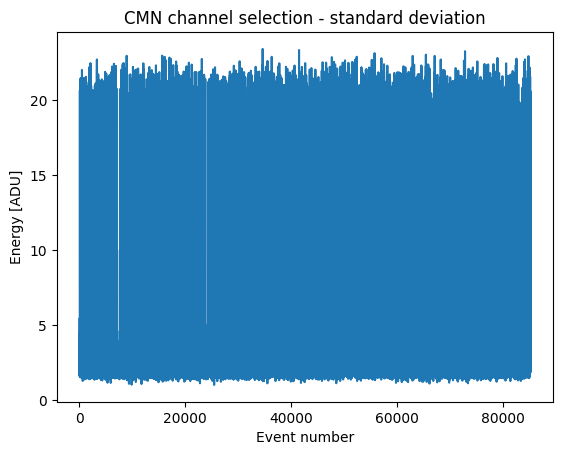

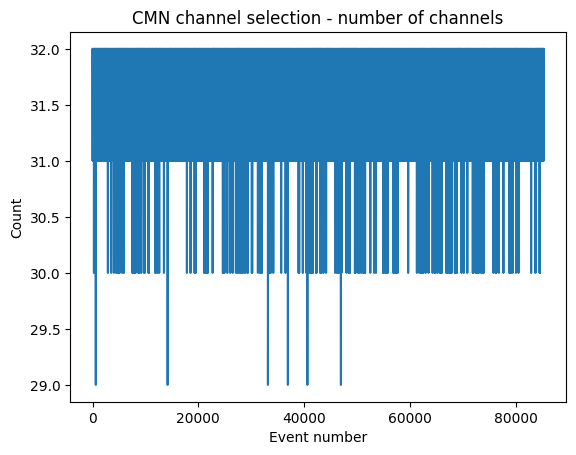

In [14]:
# Determine the common mode noise selection matrix and plot the standard deviation
# of the common mode channels and their number

ch, chn, CMNraw, std = CMNchannels(events,peds,3.)
plt.plot(std)
plt.title('CMN channel selection - standard deviation'.format(i))
plt.xlabel('Event number')
plt.ylabel('Energy [ADU]')
plt.show()
plt.plot(chn)
plt.title('CMN channel selection - number of channels'.format(i))
plt.xlabel('Event number')
plt.ylabel('Count')
plt.show()

In [15]:
## Determine the good events (common mode noise standard deviation lower than
# std_val) and print how many they are, prepare the global variables for the
# common mode gain determination step.

n = ch.shape[0]
std_val = 14.
idx = (std < std_val).nonzero()[0]
good = len(idx)
print('Number of good events (cmn std < {}): {}'.format(std_val, good))
global cmnEv
global cmnCh
cmnEv = events[idx,:]-peds
cmnEv = cmnEv[:,chMask]
cmnCh = ch[idx,:]

Number of good events (cmn std < 14.0): 84285


In [16]:
# Find the common mode noise coupling to the channels (common mode noise gain).
# p are the parameters of the minimization (the gains). This is also slow...

p = np.ones((1,len(chMask)), dtype=float)

result = minimize(cmnGain, p, method='Nelder-Mead', options={'maxiter': 1e6, 'disp': True, 'adaptive': True})

# alternative minimization method with bounds
#bnds = np.ones((len(chMask),2), dtype=float)
#bnds[:,0] = 0.8
#bnds[:,1] = 1.2
#result = minimize(cmnGain, p, method='SLSQP', bounds=(bnds), options={'maxiter': 1e3, 'disp': True})

C:\Users\ghisl\AppData\Local\Temp\ipykernel_10568\2235674991.py:6: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  result = minimize(cmnGain, p, method='Nelder-Mead', options={'maxiter': 1e6, 'disp': True, 'adaptive': True})


Optimization terminated successfully.
         Current function value: 15233389.657918
         Iterations: 1860
         Function evaluations: 2982


Common mode gains:
 [0.82075369 0.86877066 1.01978754 0.99587307 1.03682544 1.00663074
 0.98526324 0.97892305 1.00445597 1.04901124 1.01785981 1.10683456
 1.10585894 1.12752311 1.19262818 1.26488659 1.16608981 1.10220706
 1.08353166 1.0940198  1.05456894 0.98497171 0.99581533 1.02013779
 0.84847747 0.89809305 0.90061937 0.88040528 0.86791976 0.84878785
 0.83654794 0.87999884] 

Sum of gains:  32.04407748723681


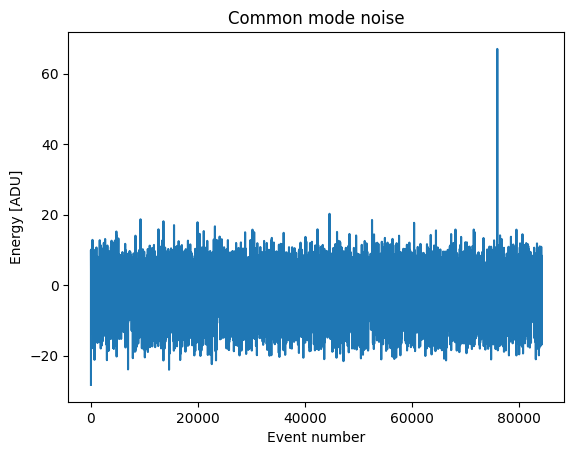

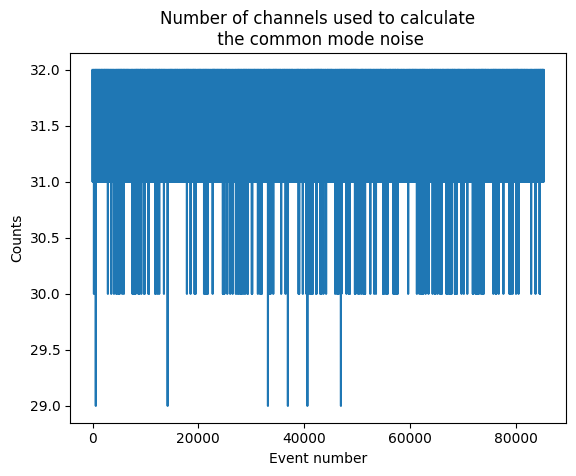

In [17]:
# remove the common mode noise (disturbances) from the event data, print the
# common mode noise gains, and plot the common mode noise along with the number
# of channels used to calculate it. The output is the variable Energy containing
# the pedestal and common mode noise subtracted event data for the good events
# (good as defined above)

g = result.x
print('Common mode gains:\n', g, '\n')
print('Sum of gains: ', g.sum())
idx = (std < std_val).nonzero()[0]
ev_good = events[idx,:]
ch_good = ch[idx,:]
energy, cmn = removeDisturbances(ev_good, peds, ch_good, g)
plt.plot(cmn)
plt.title('Common mode noise')
plt.xlabel('Event number')
plt.ylabel('Energy [ADU]')
plt.show()
plt.plot(chn)
plt.title('Number of channels used to calculate\n the common mode noise'.format(i))
plt.xlabel('Event number')
plt.ylabel('Counts')
plt.show()

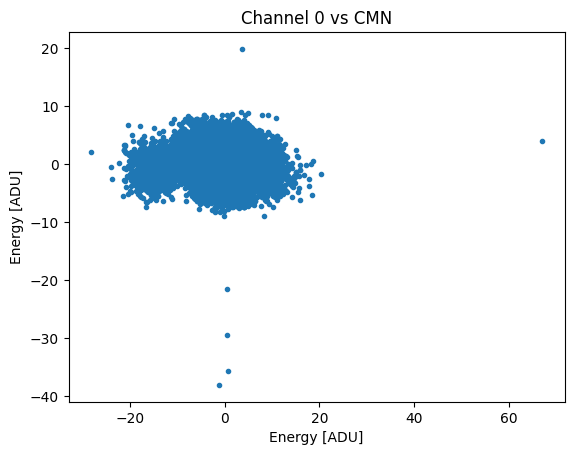

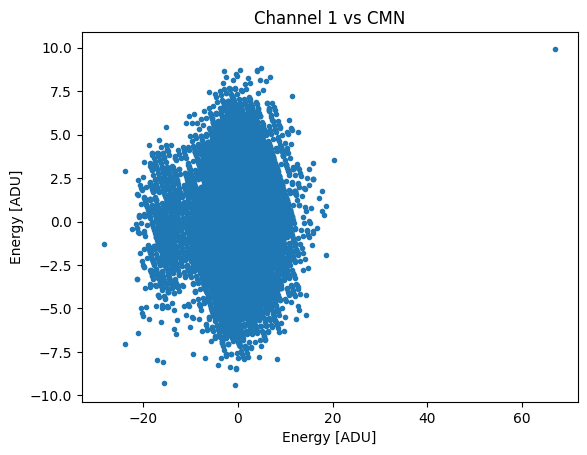

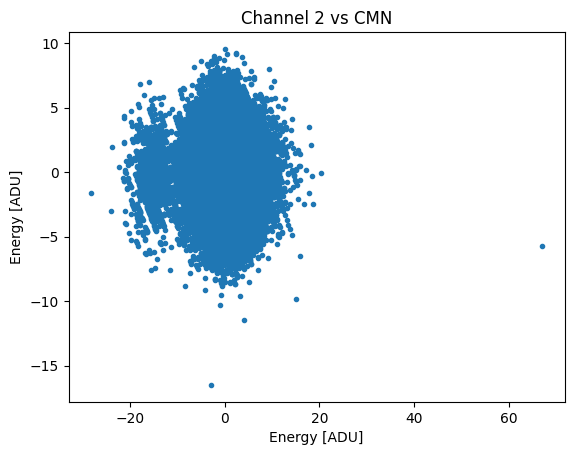

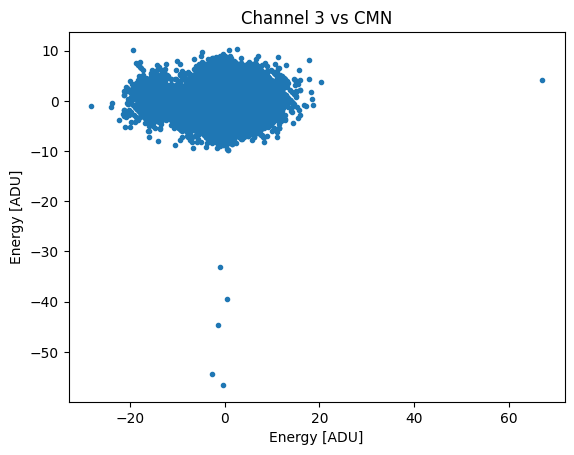

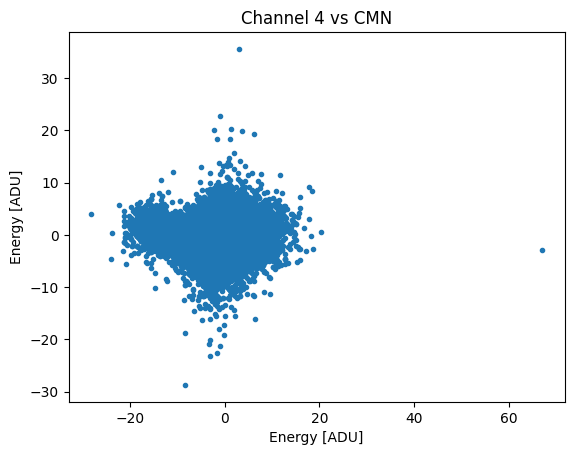

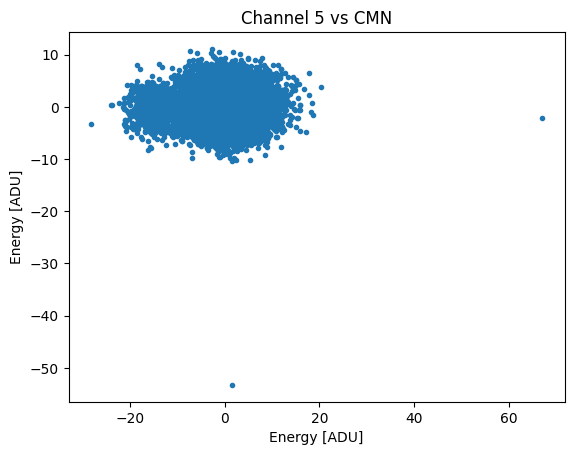

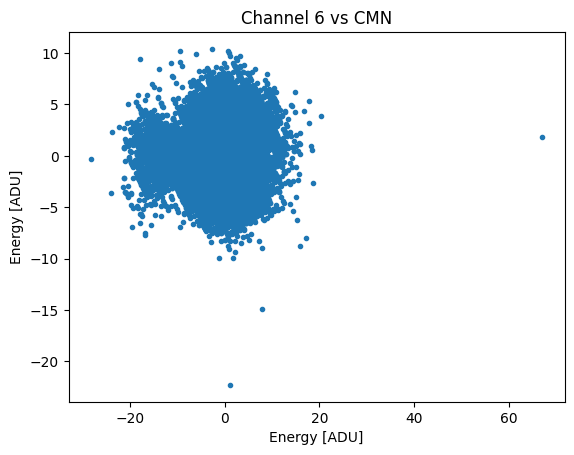

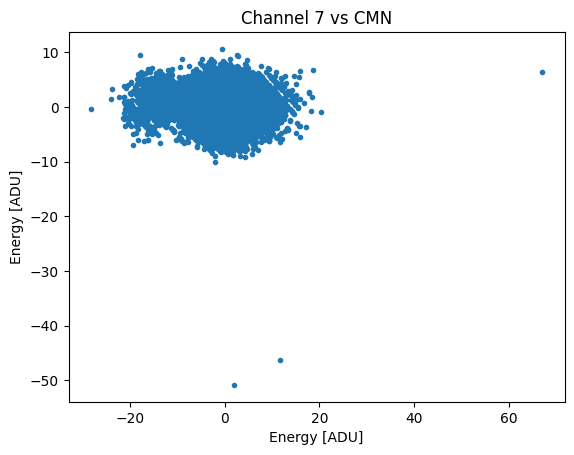

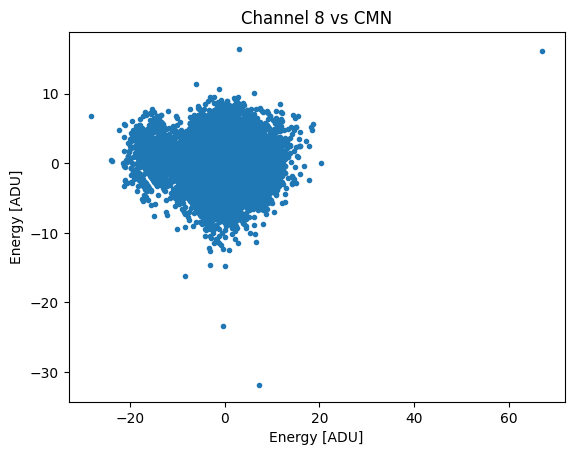

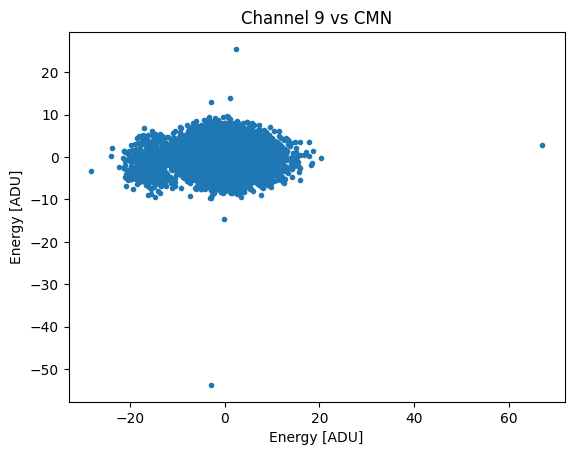

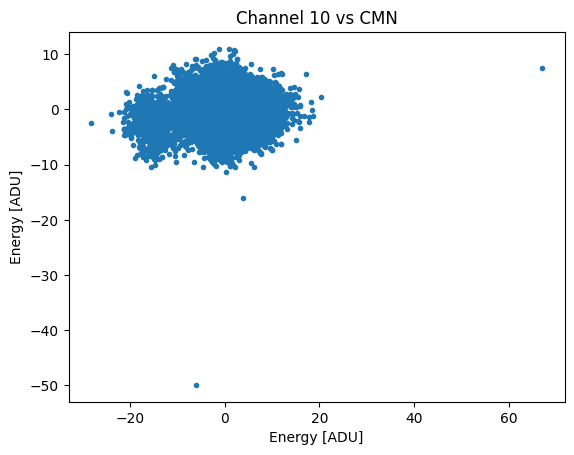

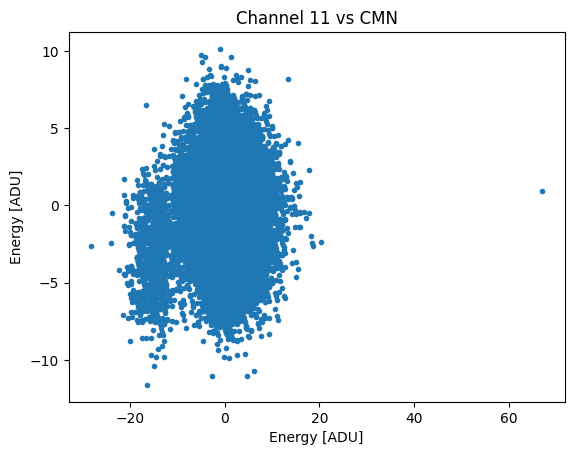

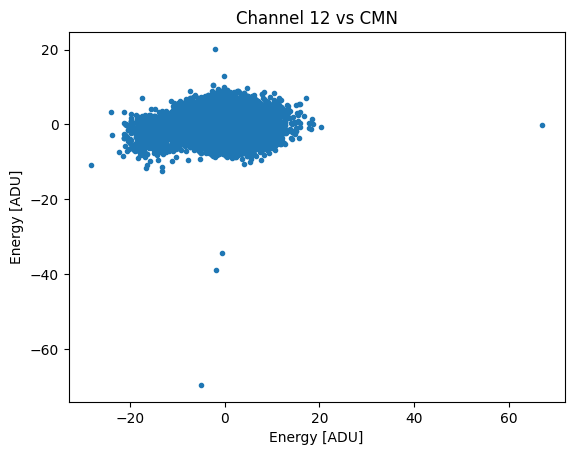

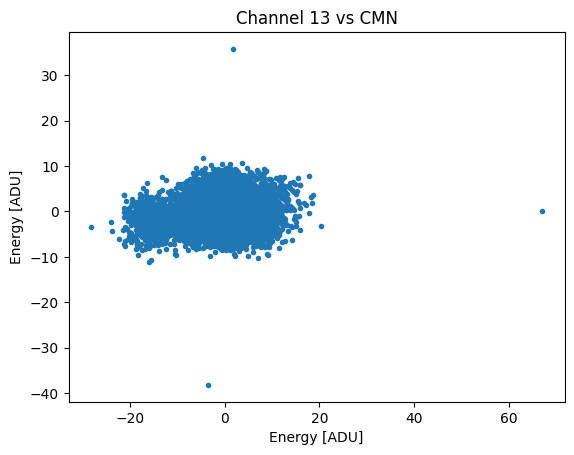

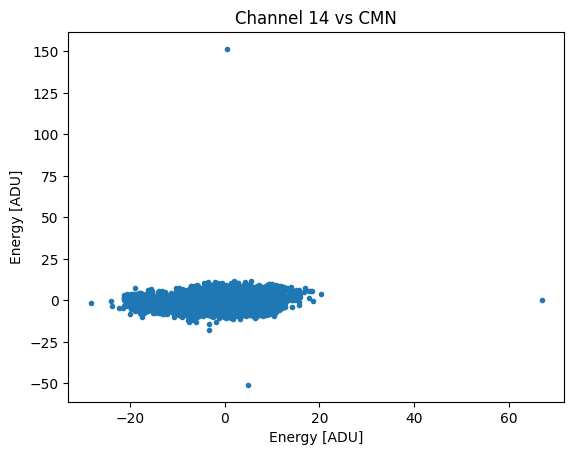

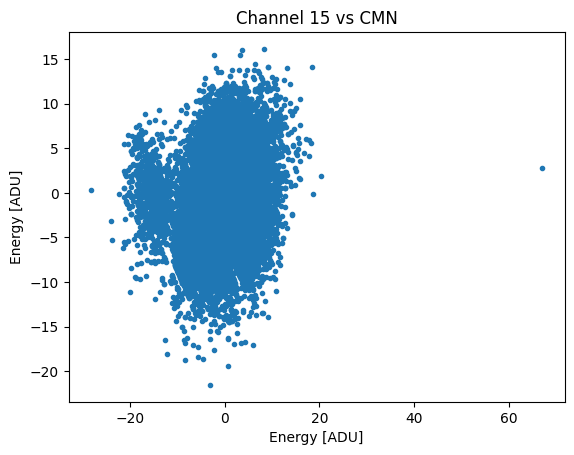

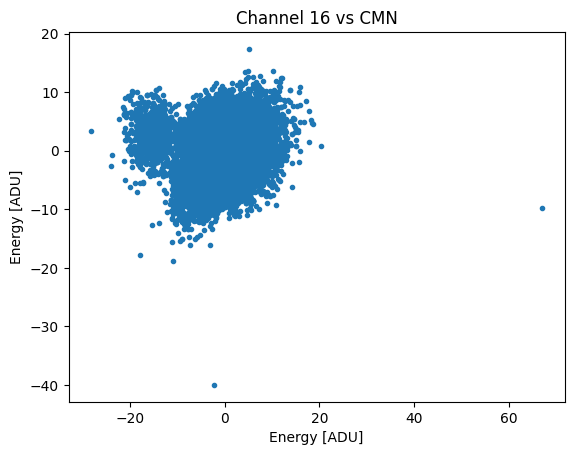

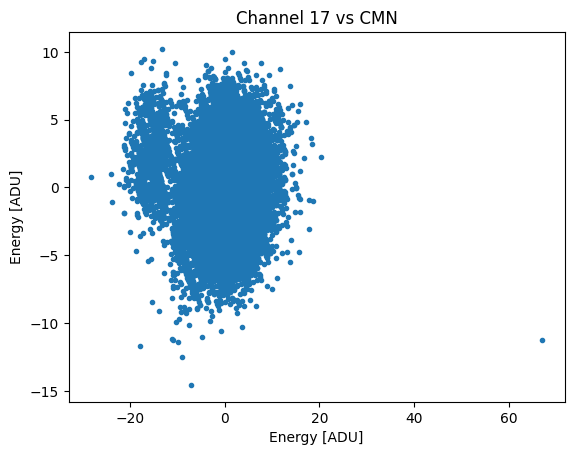

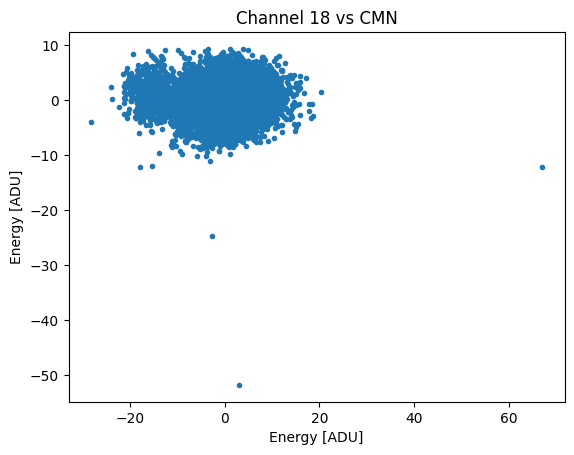

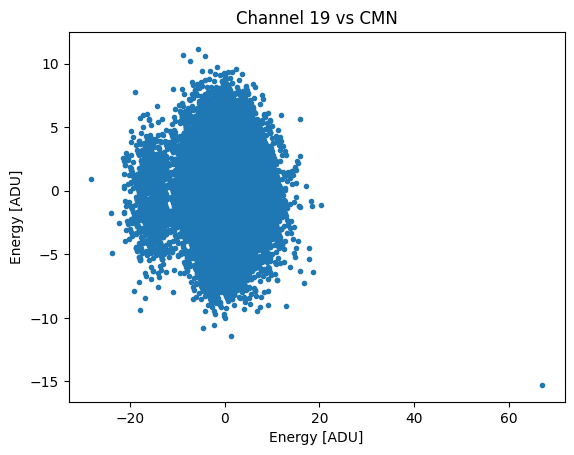

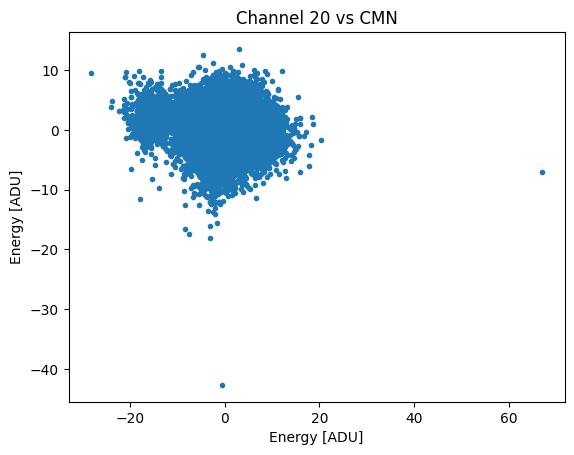

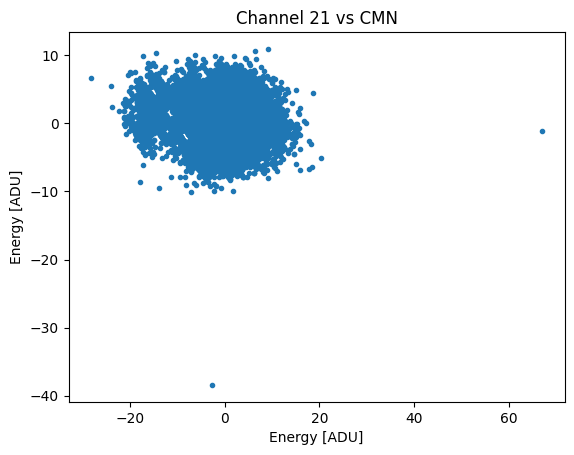

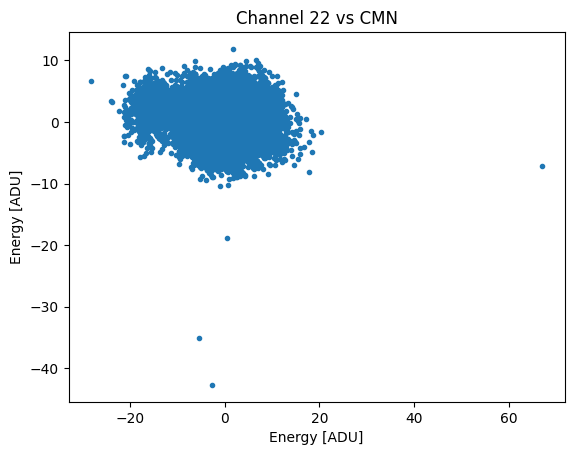

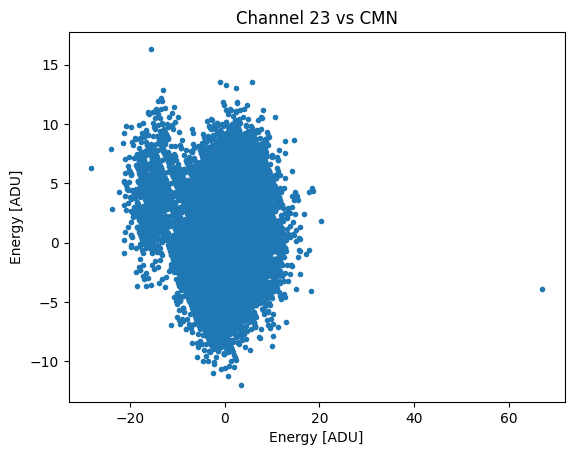

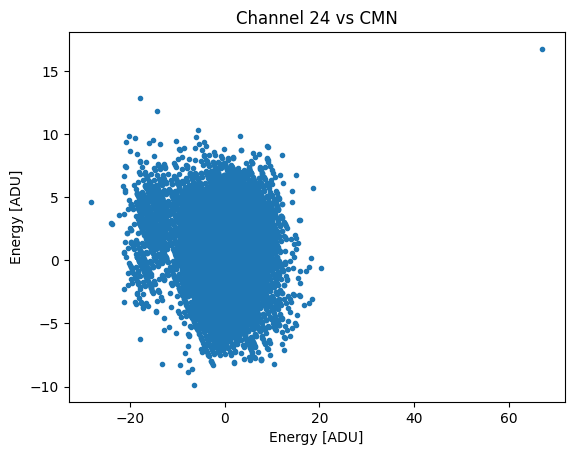

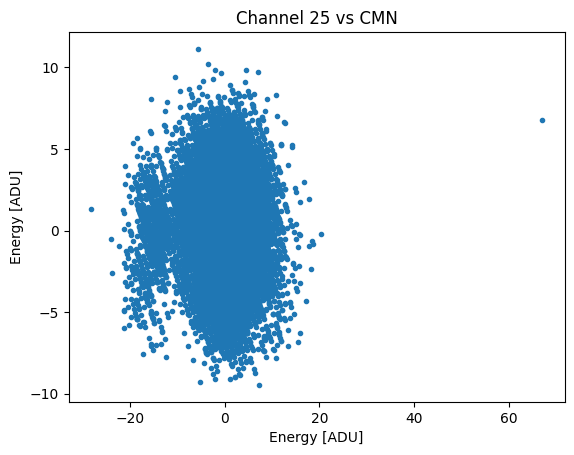

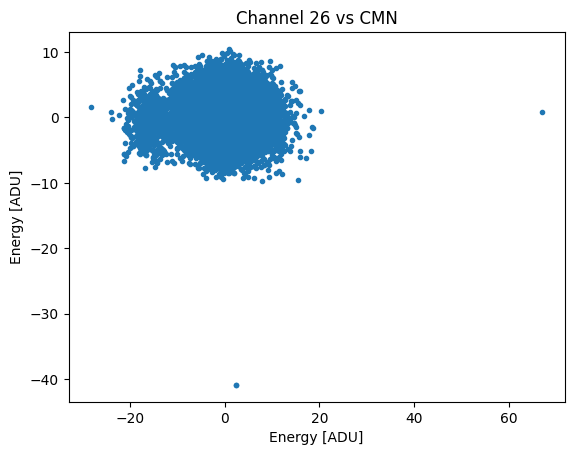

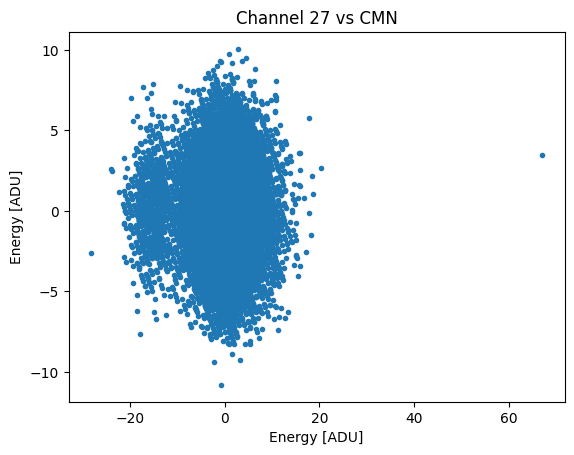

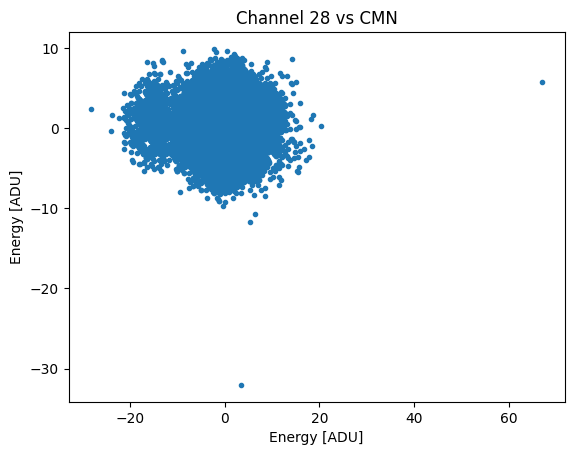

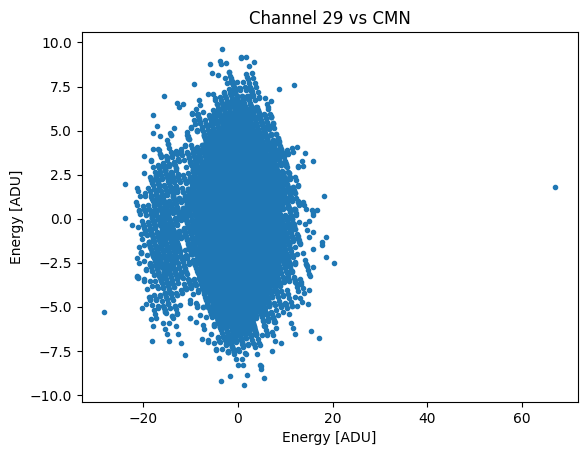

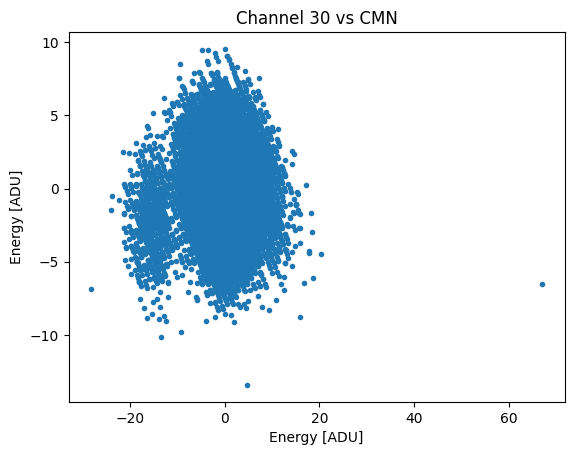

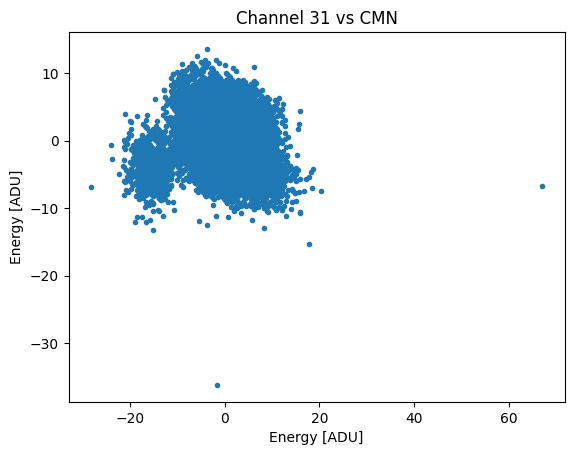

In [18]:
# Show correlation plots of the Energy data with respect to the common mode noise

for i in range(32):
    plt.plot(cmn, energy[:,i],'.')
    plt.title('Channel {} vs CMN'.format(i))
    plt.xlabel('Energy [ADU]')
    plt.ylabel('Energy [ADU]')
    plt.show()

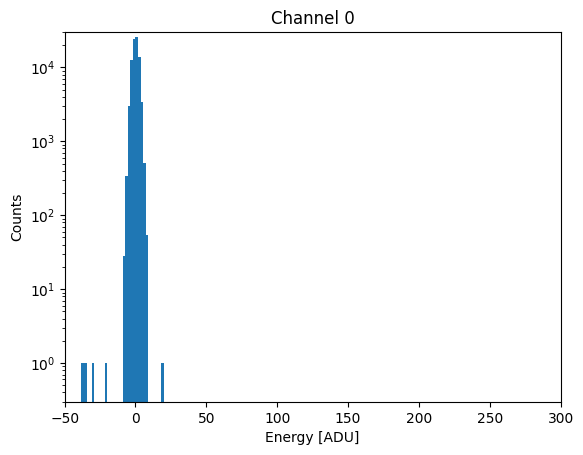

Saved ch 0


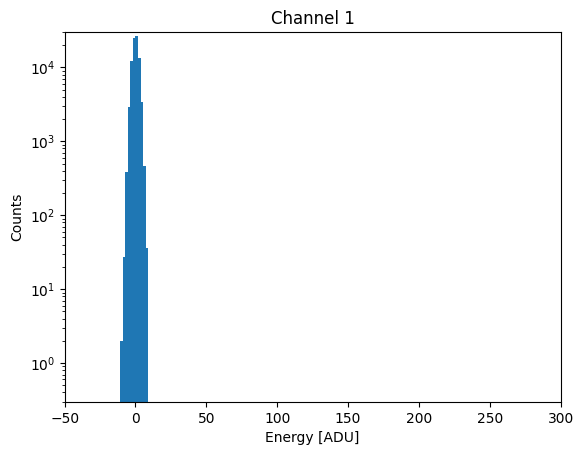

Saved ch 1


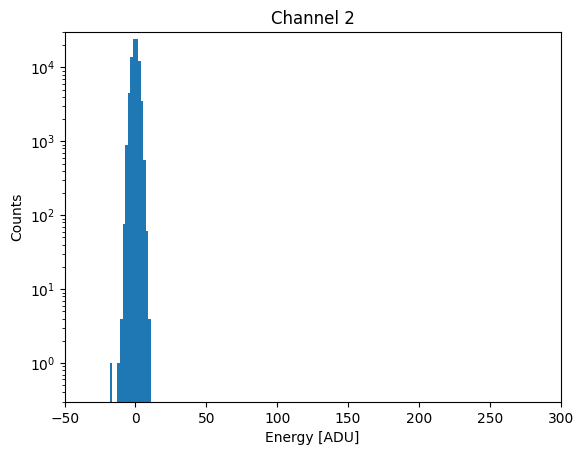

Saved ch 2


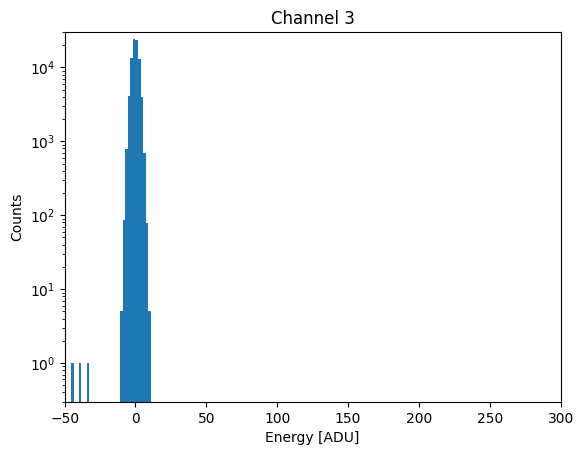

Saved ch 3


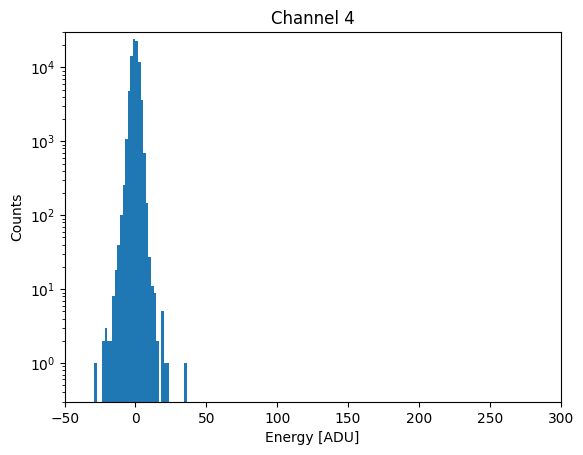

Saved ch 4


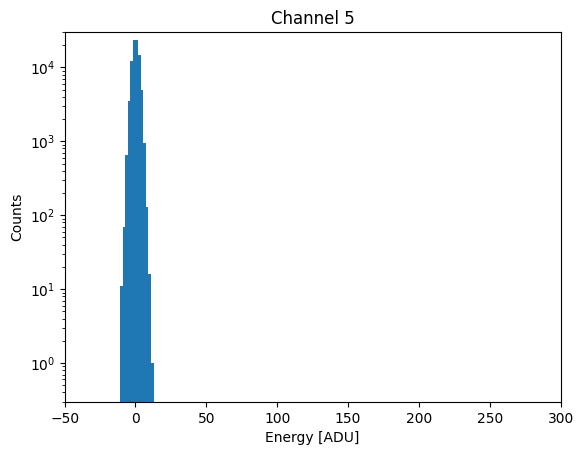

Saved ch 5


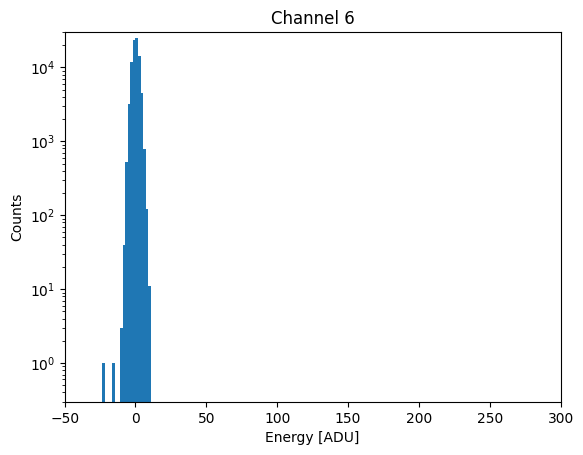

Saved ch 6


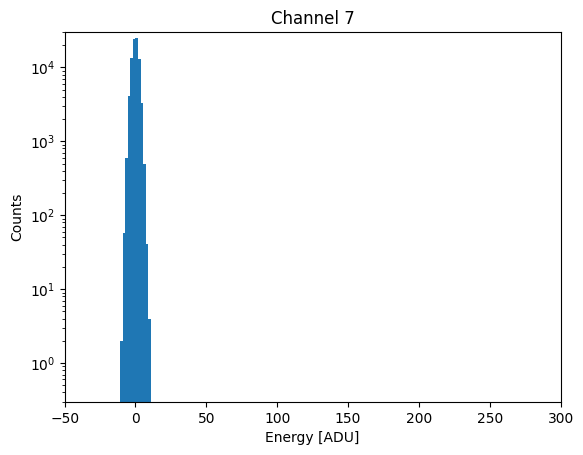

Saved ch 7


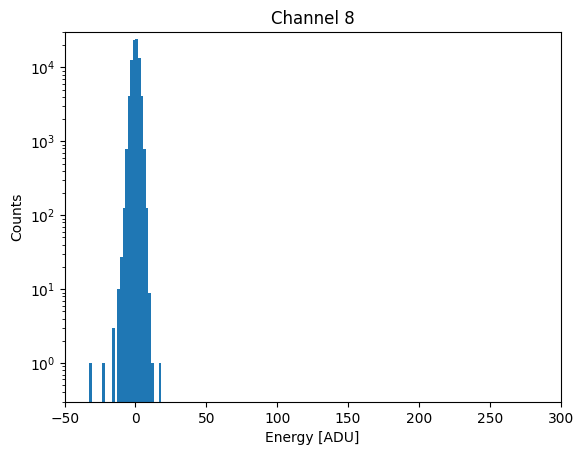

Saved ch 8


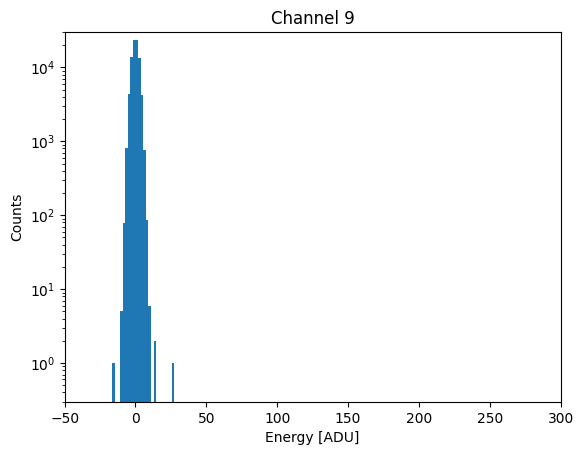

Saved ch 9


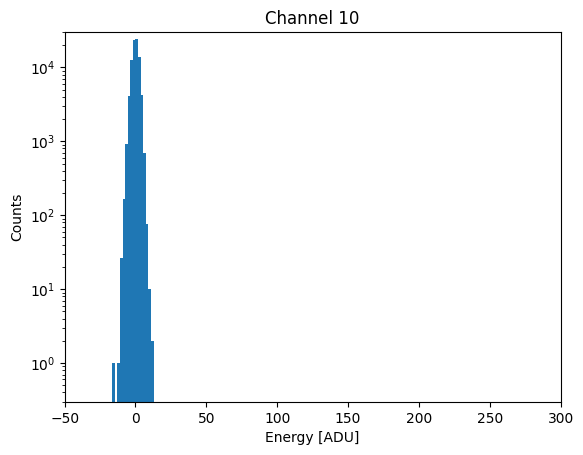

Saved ch 10


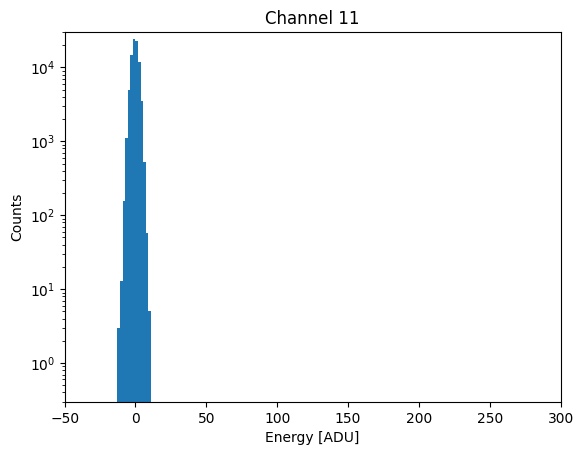

Saved ch 11


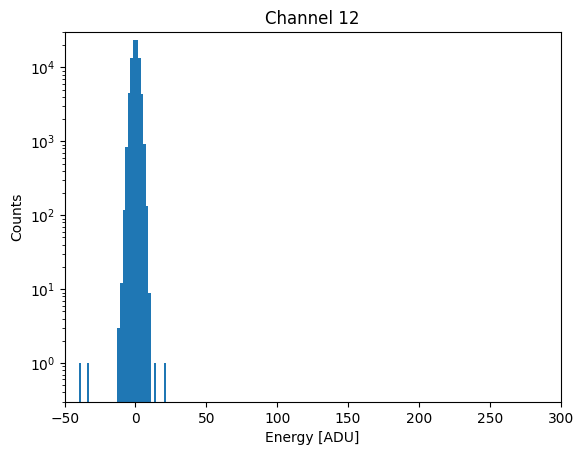

Saved ch 12


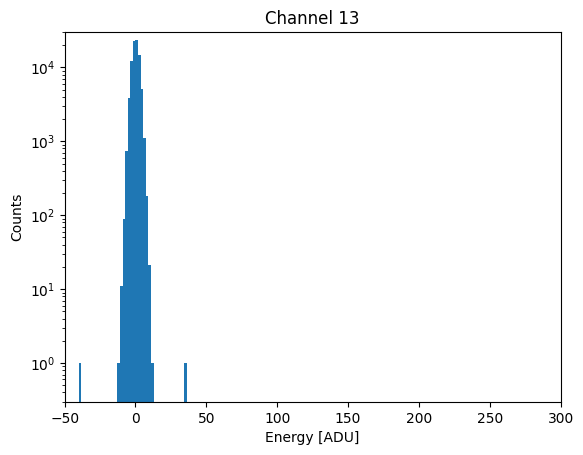

Saved ch 13


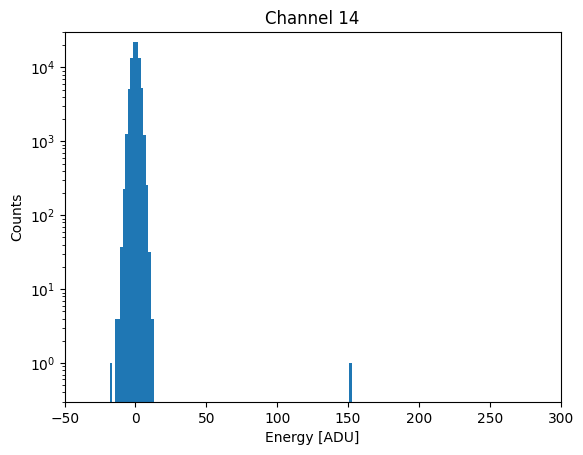

Saved ch 14


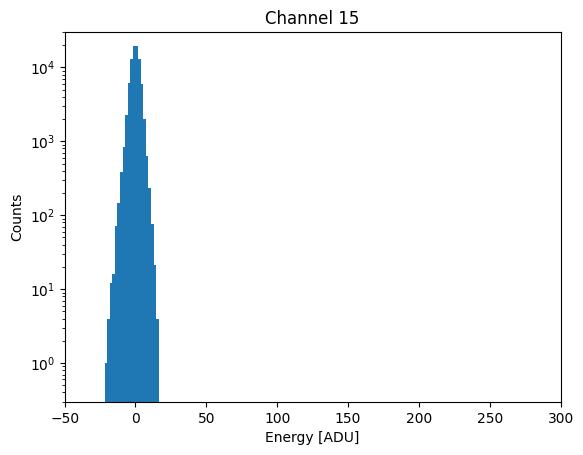

Saved ch 15


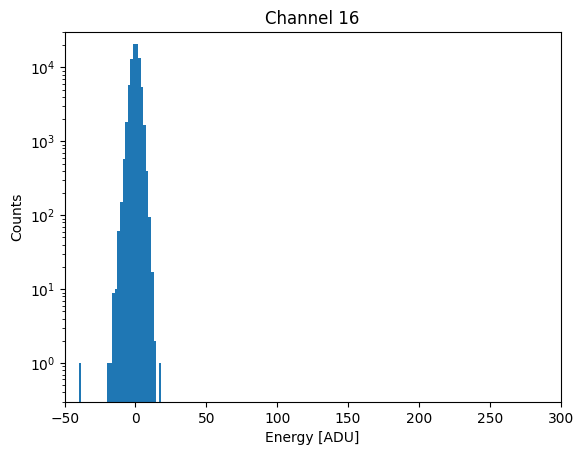

Saved ch 16


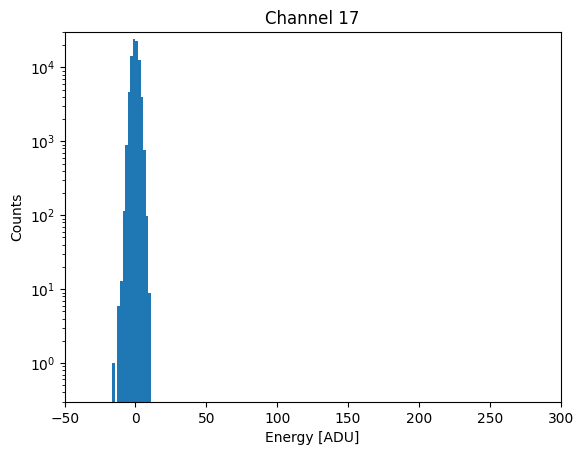

Saved ch 17


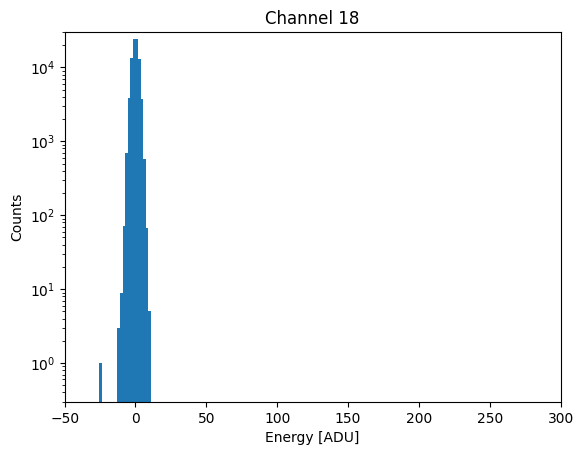

Saved ch 18


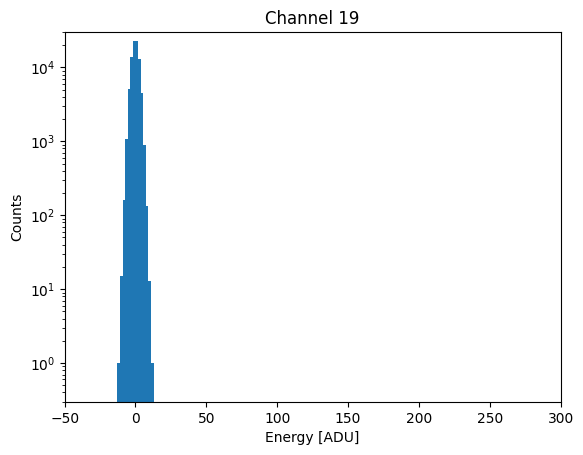

Saved ch 19


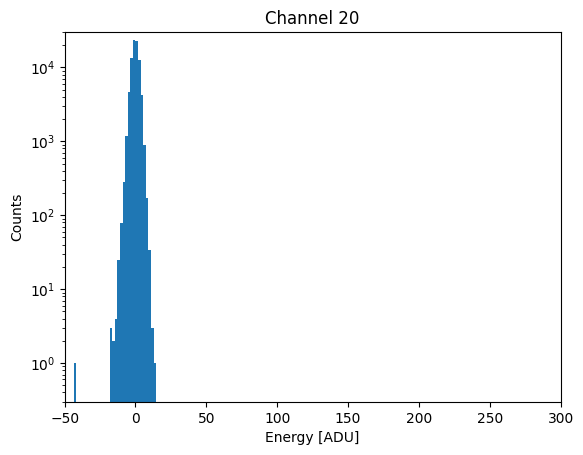

Saved ch 20


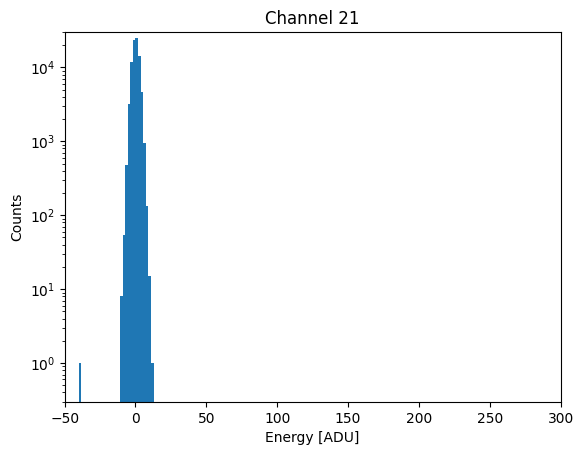

Saved ch 21


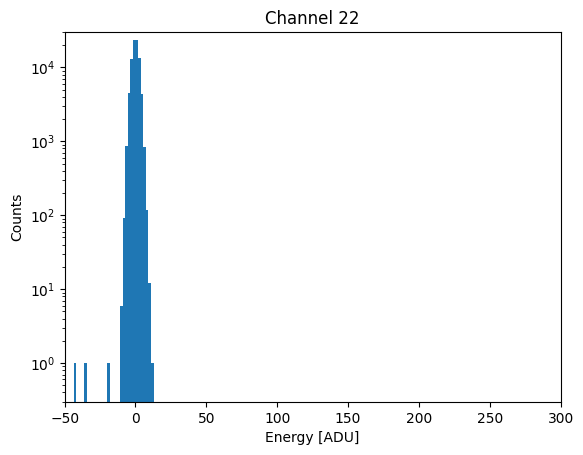

Saved ch 22


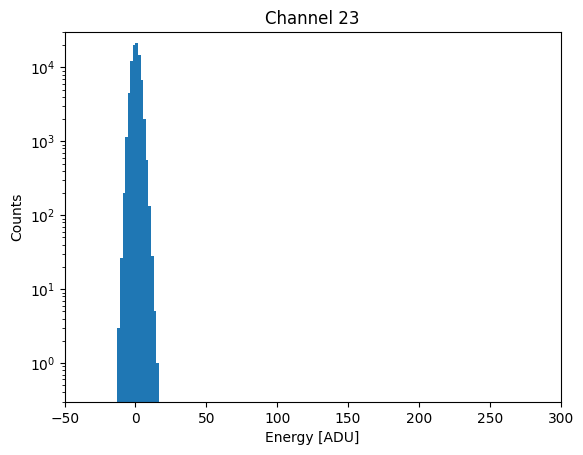

Saved ch 23


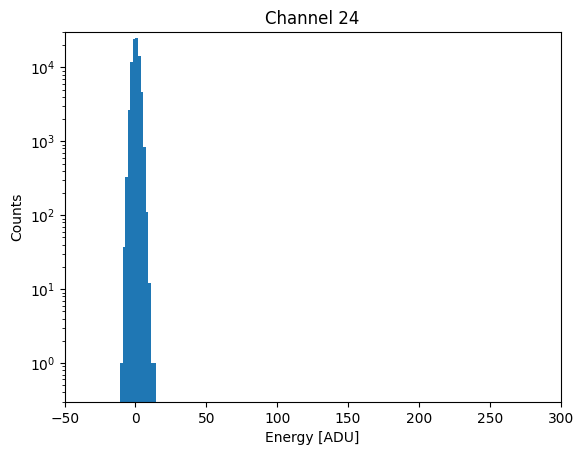

Saved ch 24


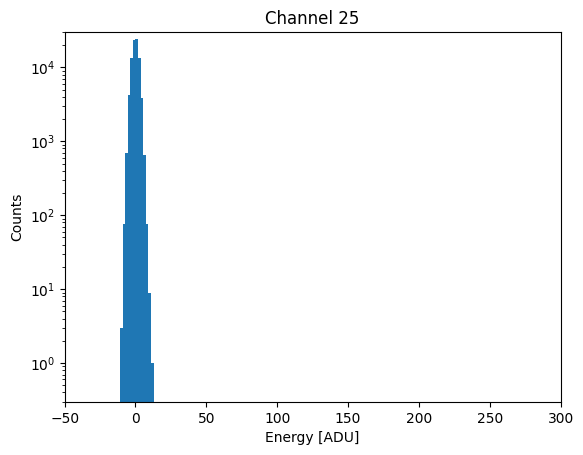

Saved ch 25


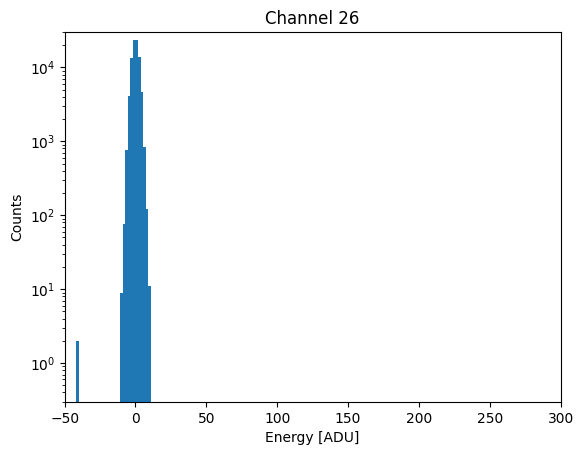

Saved ch 26


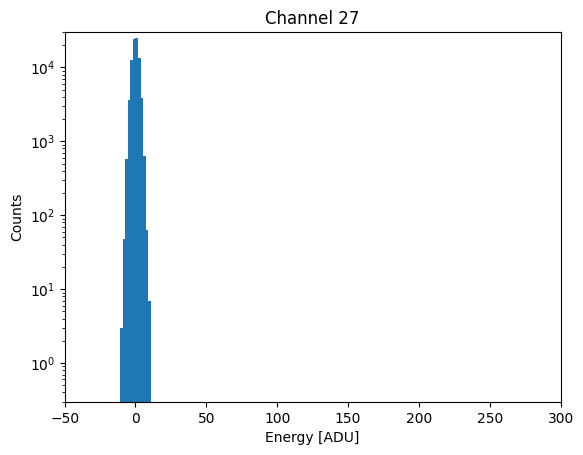

Saved ch 27


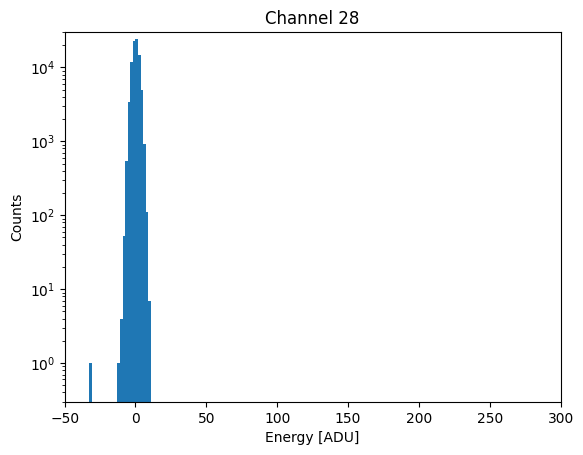

Saved ch 28


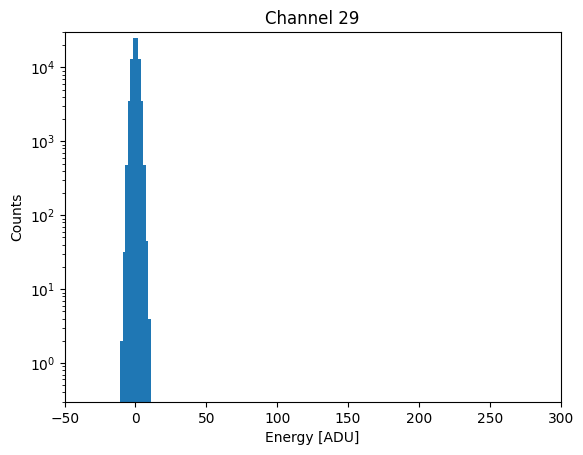

Saved ch 29


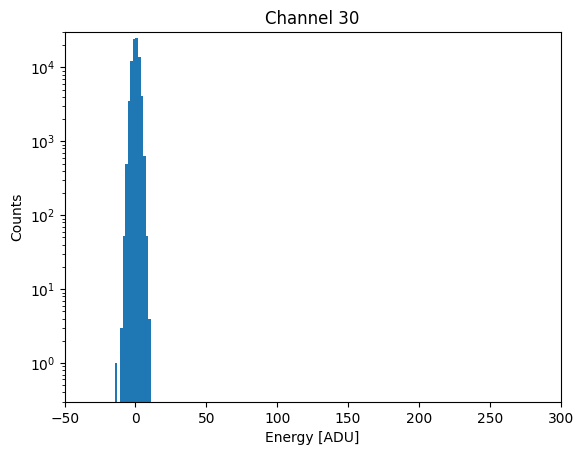

Saved ch 30


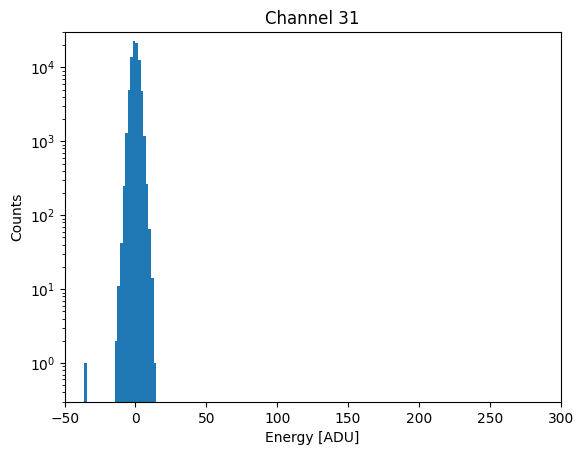

Saved ch 31


<Figure size 640x480 with 0 Axes>

In [19]:
# Plot the Energy histogram for all channels. These histograms should have a
# pedestal peak and the MIP signal (if present)

if not path.exists(fname_noext):
    mkdir(fname_noext)
    
pdf_path = path.join(fname_noext, "pdf")
    
if not path.exists(pdf_path):
    mkdir(pdf_path)
                   
png_path = path.join(fname_noext, "png")
    
if not path.exists(png_path):
    mkdir(png_path)
    
csv_path = path.join(fname_noext, "csv")
    
if not path.exists(csv_path):
    mkdir(csv_path)

for i in range(32):
    idx = (cmn < 10).nonzero()[0] # select the events where the signal is present
    plt.hist(energy[idx,i],220,(-100,300))
    plt.semilogy()
    plt.title('Channel {}'.format(i))
    plt.xlabel('Energy [ADU]')
    plt.ylabel('Counts')
    plt.axis([-50, 300, 0.3, 30000])
    
    plt.savefig(path.join(pdf_path, "ch" + str(i) + ".pdf")) 
    plt.savefig(path.join(png_path, "ch" + str(i) + ".png")) 
    
    plt.show()
    plt.clf() 

    my_df = pd.DataFrame(energy[idx, i])
    my_df.to_csv(path.join(csv_path, "ch" + str(i) + ".csv"), header = False, index= False)
    
    print("Saved ch " + str(i))
   

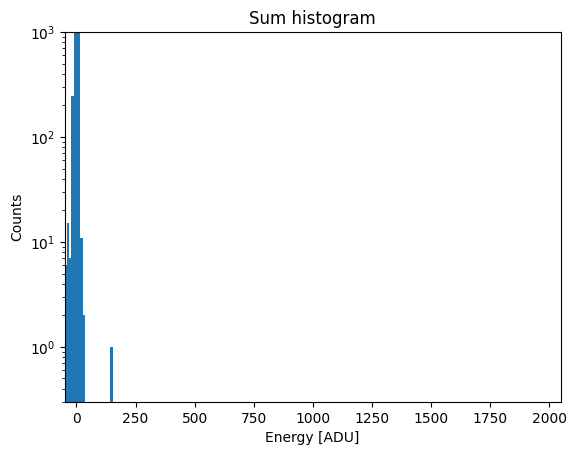

In [20]:
# Plot the sum histogram of the Energy of all active channels. Keep in mind that the channel
# gains are not equalized, this should be performed in a further step when every channel
# has a muon peak

energyActive = energy[idx,:]
energyActive = energyActive[:,chMask]
plt.hist((energyActive).flatten(),220,(-100,2047))
plt.semilogy()
plt.title('Sum histogram')
plt.xlabel('Energy [ADU]')
plt.ylabel('Counts')
plt.axis([-50, 2047, 0.3, 1000])
plt.show()

In [21]:
# Determine the new pedestal and electronics noise of the channels after
# pedestal and common mode noise subtraction

pedestals, noise = histParameters(energy[idx,:], 50, nsigma = 3.)
print ('Histogram pedestals:\n', pedestals, '\n')
print ('Histogram standard deviations:\n', noise)

Histogram pedestals:
 [ 0.10162909  0.08568229 -0.13325806 -0.02085329 -0.2133535   0.18701287
  0.18901119 -0.06109209  0.05126498 -0.03143856  0.04627645 -0.23467274
  0.01082923  0.18524746  0.00870971 -0.04691567 -0.0322747  -0.11491416
 -0.04025949 -0.0697132  -0.07759482  0.23116099  0.00194421  0.30535791
  0.24375919 -0.02084919  0.04659219  0.05192818  0.21298366  0.01263138
  0.11120006 -0.07552098] 

Histogram standard deviations:
 [2.11692279 2.07928431 2.25515415 2.28557243 2.31912767 2.31605755
 2.22509458 2.18783125 2.28149314 2.32560106 2.30267588 2.31087485
 2.35809445 2.37302346 2.53031789 2.94800179 2.73968355 2.33463054
 2.22127581 2.42624872 2.39164045 2.24646531 2.3490556  2.67220435
 2.17649224 2.2628565  2.34032941 2.19082771 2.28222587 2.145868
 2.20100006 2.50879446]


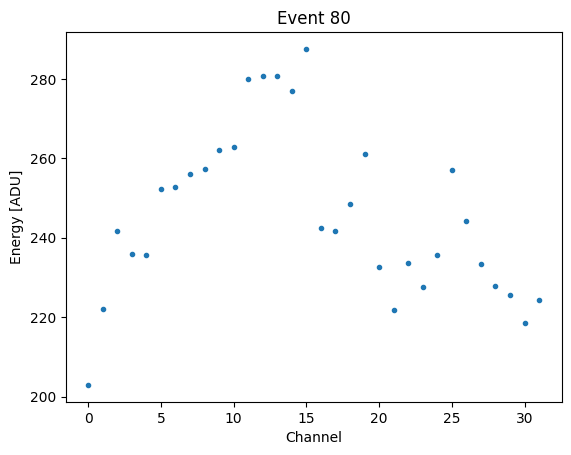

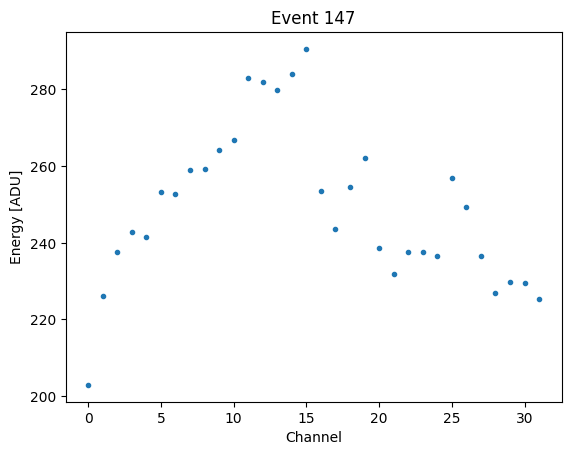

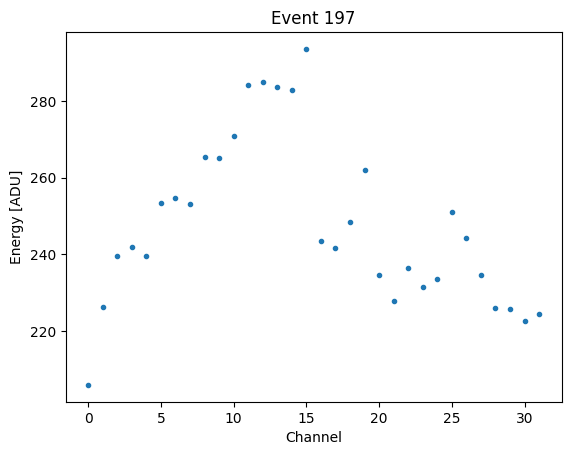

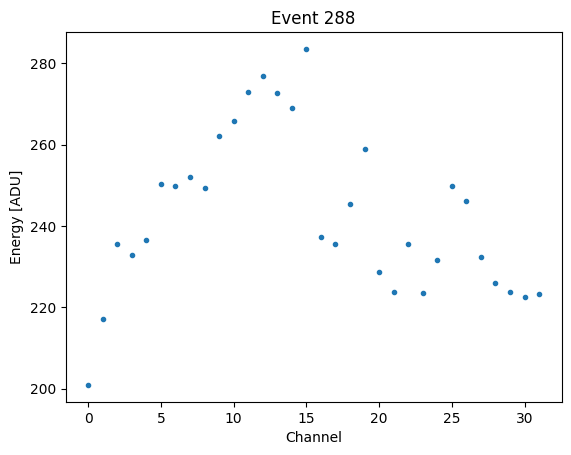

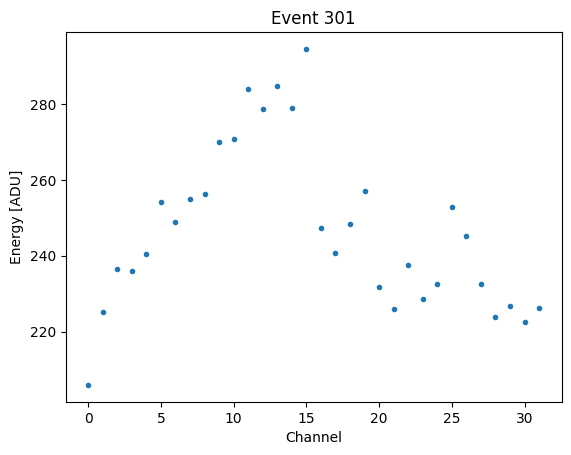

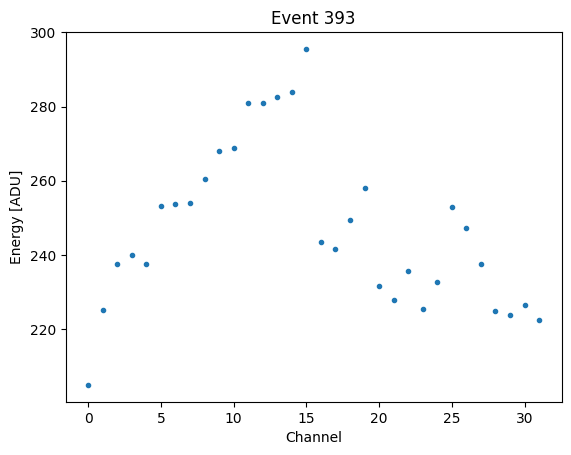

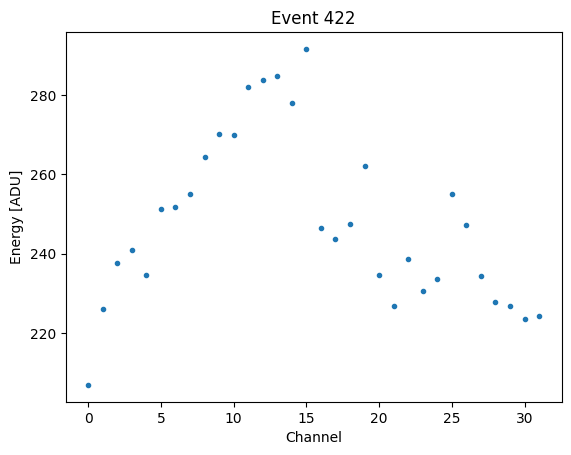

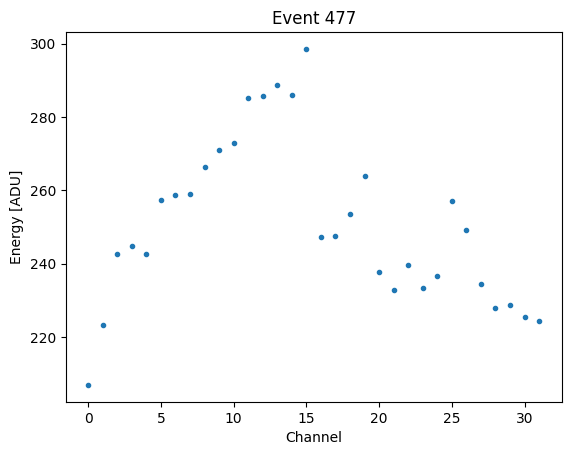

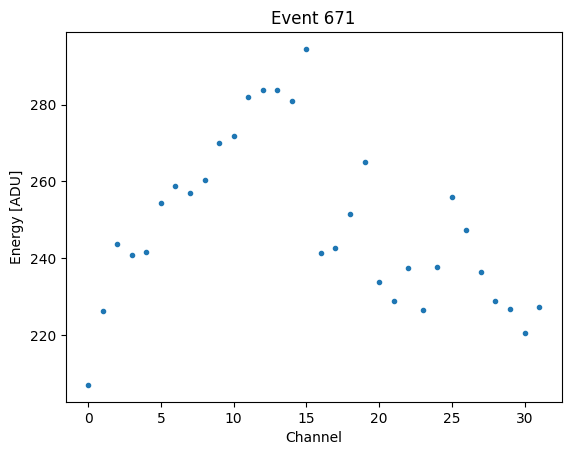

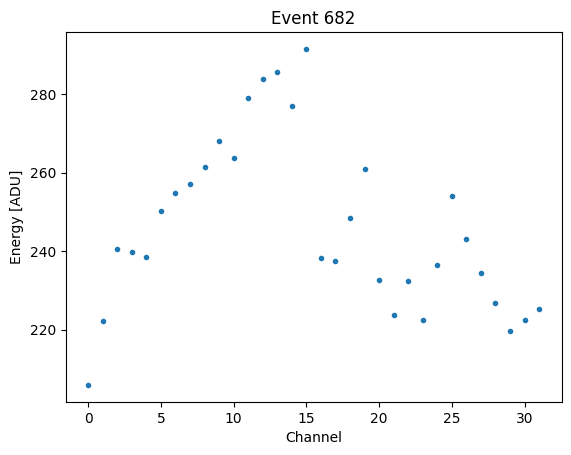

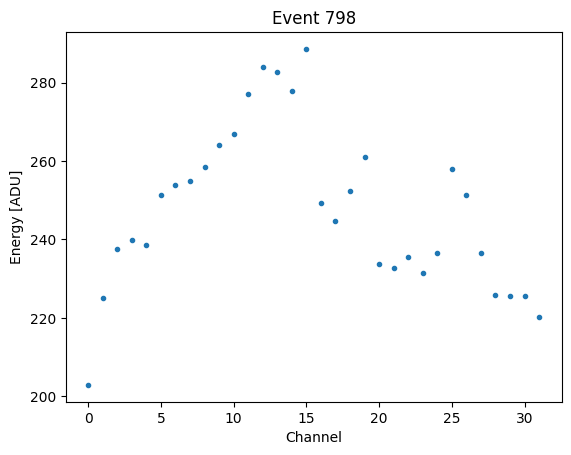

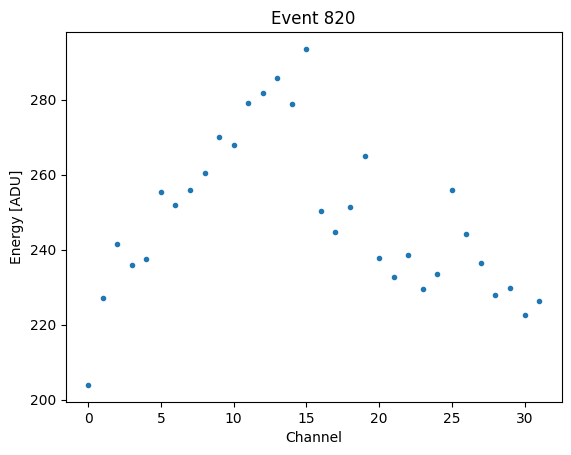

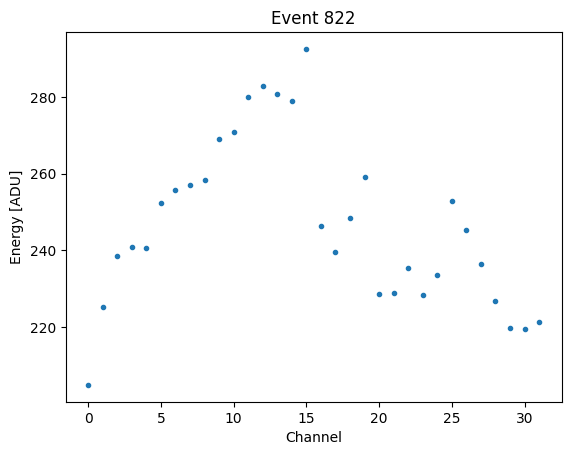

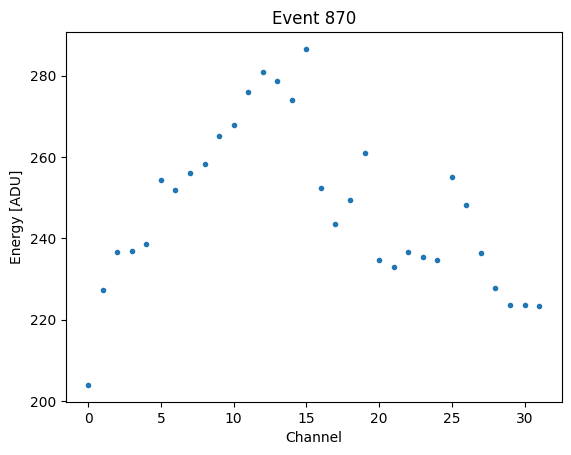

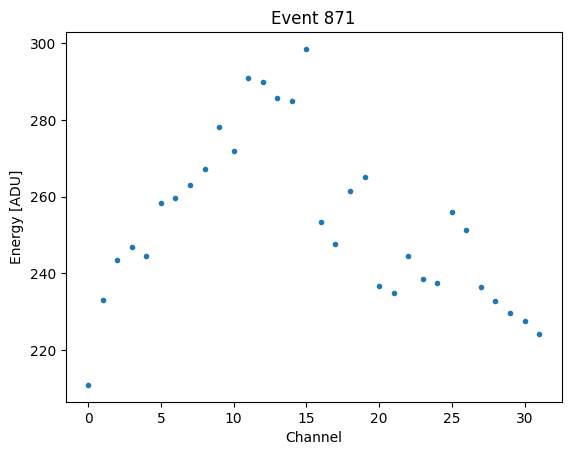

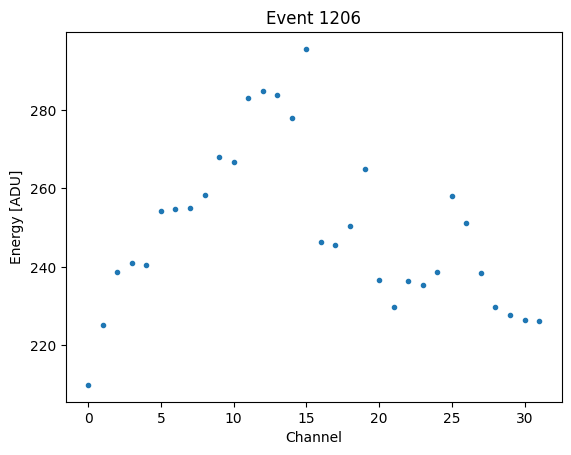

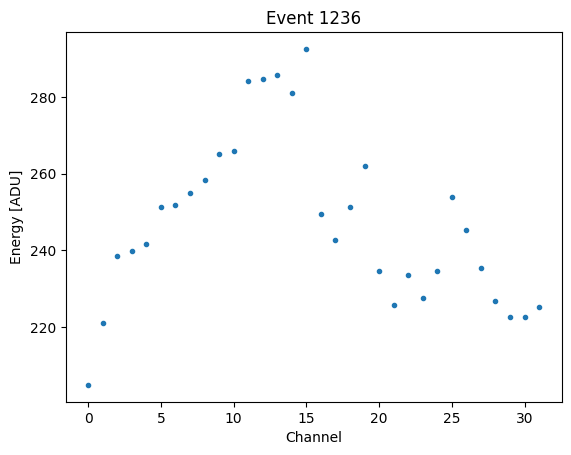

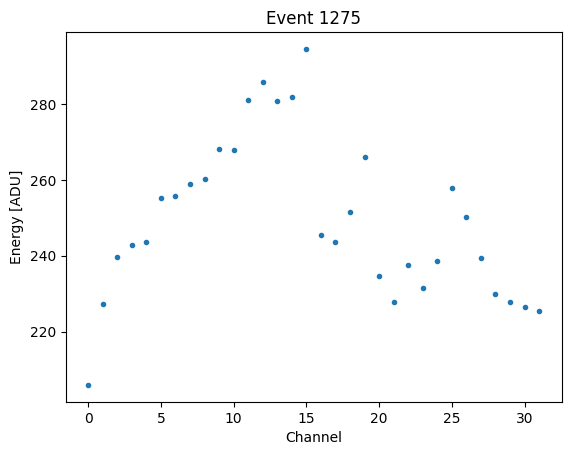

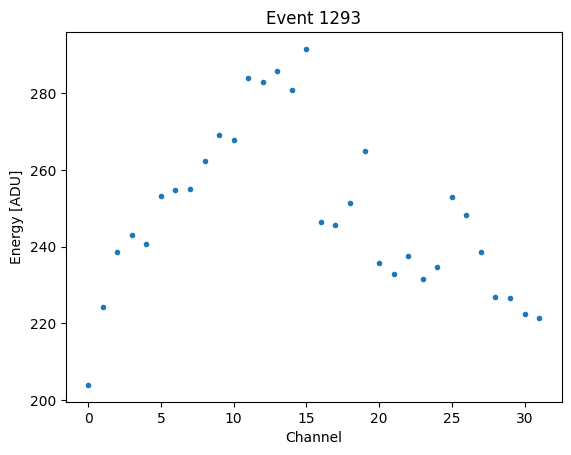

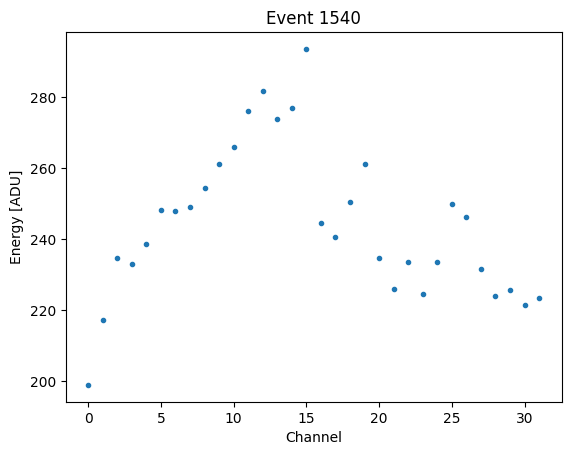

In [22]:
# Plot the first 20 bad events (pedestal subtracted data) to have a look at them

idx = (std >= std_val).nonzero()[0]
ev_bad = events[idx,:]-peds
for i in range(min(20, len(idx))):
    plt.plot(ev_bad[i,:],'.')
    plt.title('Event {}'.format(idx[i]))
    plt.xlabel('Channel')
    plt.ylabel('Energy [ADU]')
    plt.show()